# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: max


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:18:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:18:45] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:19:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:19:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:19:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:19:58] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.8248481886733738
Average Accuracy: 0.7653132608621103
Average Precision: 0.7248144078591607
Average Recall: 0.6540649496080626


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))

/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:20:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:20:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:20:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:21:15] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:21:35] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.8042167124101631
Average Accuracy: 0.7479098796337574
Average Precision: 0.7038233451004059
Average Recall: 0.622508398656215


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66618


[1]	validation_0-logloss:0.66315


[2]	validation_0-logloss:0.66122


[3]	validation_0-logloss:0.65883


[4]	validation_0-logloss:0.65639


[5]	validation_0-logloss:0.65422


[6]	validation_0-logloss:0.65241


[7]	validation_0-logloss:0.65017


[8]	validation_0-logloss:0.64732


[9]	validation_0-logloss:0.64507


[10]	validation_0-logloss:0.64229


[11]	validation_0-logloss:0.64000


[12]	validation_0-logloss:0.63757


[13]	validation_0-logloss:0.63491


[14]	validation_0-logloss:0.63270


[15]	validation_0-logloss:0.63044


[16]	validation_0-logloss:0.62838


[17]	validation_0-logloss:0.62681


[18]	validation_0-logloss:0.62540


[19]	validation_0-logloss:0.62375


[20]	validation_0-logloss:0.62136


[21]	validation_0-logloss:0.61939


[22]	validation_0-logloss:0.61747


[23]	validation_0-logloss:0.61636


[24]	validation_0-logloss:0.61565


[25]	validation_0-logloss:0.61399


[26]	validation_0-logloss:0.61234


[27]	validation_0-logloss:0.61081


[28]	validation_0-logloss:0.60916


[29]	validation_0-logloss:0.60740


[30]	validation_0-logloss:0.60538


[31]	validation_0-logloss:0.60327


[32]	validation_0-logloss:0.60136


[33]	validation_0-logloss:0.60000


[34]	validation_0-logloss:0.59863


[35]	validation_0-logloss:0.59695


[36]	validation_0-logloss:0.59567


[37]	validation_0-logloss:0.59427


[38]	validation_0-logloss:0.59316


[39]	validation_0-logloss:0.59201


[40]	validation_0-logloss:0.59028


[41]	validation_0-logloss:0.58892


[42]	validation_0-logloss:0.58732


[43]	validation_0-logloss:0.58584


[44]	validation_0-logloss:0.58455


[45]	validation_0-logloss:0.58319


[46]	validation_0-logloss:0.58204


[47]	validation_0-logloss:0.58118


[48]	validation_0-logloss:0.58035


[49]	validation_0-logloss:0.57888


[50]	validation_0-logloss:0.57770


[51]	validation_0-logloss:0.57617


[52]	validation_0-logloss:0.57473


[53]	validation_0-logloss:0.57360


[54]	validation_0-logloss:0.57206


[55]	validation_0-logloss:0.57056


[56]	validation_0-logloss:0.56957


[57]	validation_0-logloss:0.56854


[58]	validation_0-logloss:0.56739


[59]	validation_0-logloss:0.56652


[60]	validation_0-logloss:0.56527


[61]	validation_0-logloss:0.56396


[62]	validation_0-logloss:0.56302


[63]	validation_0-logloss:0.56147


[64]	validation_0-logloss:0.56017


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:21:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[65]	validation_0-logloss:0.55932


[66]	validation_0-logloss:0.55846


[67]	validation_0-logloss:0.55795


[68]	validation_0-logloss:0.55693


[69]	validation_0-logloss:0.55575

[70]	validation_0-logloss:0.55522


[71]	validation_0-logloss:0.55428

[72]	validation_0-logloss:0.55373


[73]	validation_0-logloss:0.55276


[74]	validation_0-logloss:0.55239


[75]	validation_0-logloss:0.55136


[76]	validation_0-logloss:0.55029


[77]	validation_0-logloss:0.54925


[78]	validation_0-logloss:0.54839


[79]	validation_0-logloss:0.54777


[80]	validation_0-logloss:0.54664


[81]	validation_0-logloss:0.54615


[82]	validation_0-logloss:0.54527


[83]	validation_0-logloss:0.54443


[84]	validation_0-logloss:0.54341


[85]	validation_0-logloss:0.54240


[86]	validation_0-logloss:0.54157


[87]	validation_0-logloss:0.54089


[88]	validation_0-logloss:0.54030


[89]	validation_0-logloss:0.53960


[90]	validation_0-logloss:0.53908


[91]	validation_0-logloss:0.53799


[92]	validation_0-logloss:0.53752


[93]	validation_0-logloss:0.53689


[94]	validation_0-logloss:0.53637


[95]	validation_0-logloss:0.53590

[96]	validation_0-logloss:0.53496


[97]	validation_0-logloss:0.53447


[98]	validation_0-logloss:0.53353


[99]	validation_0-logloss:0.53303


[100]	validation_0-logloss:0.53247


[101]	validation_0-logloss:0.53184


[102]	validation_0-logloss:0.53091


[103]	validation_0-logloss:0.53061


[104]	validation_0-logloss:0.53024


[105]	validation_0-logloss:0.52932


[106]	validation_0-logloss:0.52901


[107]	validation_0-logloss:0.52863


[108]	validation_0-logloss:0.52793


[109]	validation_0-logloss:0.52764


[110]	validation_0-logloss:0.52718


[111]	validation_0-logloss:0.52636


[112]	validation_0-logloss:0.52587


[113]	validation_0-logloss:0.52509


[114]	validation_0-logloss:0.52441


[115]	validation_0-logloss:0.52422


[116]	validation_0-logloss:0.52364


[117]	validation_0-logloss:0.52293


[118]	validation_0-logloss:0.52251


[119]	validation_0-logloss:0.52203


[120]	validation_0-logloss:0.52159


[121]	validation_0-logloss:0.52127


[122]	validation_0-logloss:0.52099


[123]	validation_0-logloss:0.52034


[124]	validation_0-logloss:0.52005


[125]	validation_0-logloss:0.51957


[126]	validation_0-logloss:0.51902


[127]	validation_0-logloss:0.51846


[128]	validation_0-logloss:0.51788


[129]	validation_0-logloss:0.51727


[130]	validation_0-logloss:0.51673


[131]	validation_0-logloss:0.51655


[132]	validation_0-logloss:0.51631


[133]	validation_0-logloss:0.51589


[134]	validation_0-logloss:0.51560


[135]	validation_0-logloss:0.51512


[136]	validation_0-logloss:0.51498


[137]	validation_0-logloss:0.51459


[138]	validation_0-logloss:0.51430


[139]	validation_0-logloss:0.51438


[140]	validation_0-logloss:0.51389


[141]	validation_0-logloss:0.51336


[142]	validation_0-logloss:0.51294


[143]	validation_0-logloss:0.51254


[144]	validation_0-logloss:0.51260


[145]	validation_0-logloss:0.51201


[146]	validation_0-logloss:0.51188


[147]	validation_0-logloss:0.51123


[148]	validation_0-logloss:0.51035


[149]	validation_0-logloss:0.51017


[150]	validation_0-logloss:0.50979


[151]	validation_0-logloss:0.50959


[152]	validation_0-logloss:0.50937


[153]	validation_0-logloss:0.50929


[154]	validation_0-logloss:0.50892


[155]	validation_0-logloss:0.50851


[156]	validation_0-logloss:0.50797


[157]	validation_0-logloss:0.50786


[158]	validation_0-logloss:0.50784


[159]	validation_0-logloss:0.50754


[160]	validation_0-logloss:0.50730


[161]	validation_0-logloss:0.50660


[162]	validation_0-logloss:0.50610


[163]	validation_0-logloss:0.50580


[164]	validation_0-logloss:0.50553


[165]	validation_0-logloss:0.50541


[166]	validation_0-logloss:0.50525


[167]	validation_0-logloss:0.50542


[168]	validation_0-logloss:0.50521


[169]	validation_0-logloss:0.50474


[170]	validation_0-logloss:0.50455


[171]	validation_0-logloss:0.50474


[172]	validation_0-logloss:0.50417


[173]	validation_0-logloss:0.50388


[174]	validation_0-logloss:0.50382

[175]	validation_0-logloss:0.50372


[176]	validation_0-logloss:0.50323


[177]	validation_0-logloss:0.50316


[178]	validation_0-logloss:0.50311


[179]	validation_0-logloss:0.50314


[180]	validation_0-logloss:0.50276


[181]	validation_0-logloss:0.50252


[182]	validation_0-logloss:0.50230


[183]	validation_0-logloss:0.50229


[184]	validation_0-logloss:0.50235


[185]	validation_0-logloss:0.50225


[186]	validation_0-logloss:0.50205


[187]	validation_0-logloss:0.50185


[188]	validation_0-logloss:0.50202


[189]	validation_0-logloss:0.50189


[190]	validation_0-logloss:0.50155


[191]	validation_0-logloss:0.50136


[192]	validation_0-logloss:0.50108


[193]	validation_0-logloss:0.50101


[194]	validation_0-logloss:0.50081


[195]	validation_0-logloss:0.50055


[196]	validation_0-logloss:0.50062


[197]	validation_0-logloss:0.50027


[198]	validation_0-logloss:0.50015


[199]	validation_0-logloss:0.50007


[200]	validation_0-logloss:0.49992


[201]	validation_0-logloss:0.49991


[202]	validation_0-logloss:0.49981


[203]	validation_0-logloss:0.49973


[204]	validation_0-logloss:0.49955


[205]	validation_0-logloss:0.49930

[206]	validation_0-logloss:0.49908


[207]	validation_0-logloss:0.49885


[208]	validation_0-logloss:0.49892


[209]	validation_0-logloss:0.49918


[210]	validation_0-logloss:0.49919


[211]	validation_0-logloss:0.49913


[212]	validation_0-logloss:0.49902


[213]	validation_0-logloss:0.49891


[214]	validation_0-logloss:0.49897


[215]	validation_0-logloss:0.49853


[216]	validation_0-logloss:0.49852


[217]	validation_0-logloss:0.49843


[218]	validation_0-logloss:0.49860

[219]	validation_0-logloss:0.49841


[220]	validation_0-logloss:0.49831


[221]	validation_0-logloss:0.49844


[222]	validation_0-logloss:0.49823


[223]	validation_0-logloss:0.49800


[224]	validation_0-logloss:0.49794


[225]	validation_0-logloss:0.49797


[226]	validation_0-logloss:0.49809


[227]	validation_0-logloss:0.49794


[228]	validation_0-logloss:0.49806


[229]	validation_0-logloss:0.49820


[230]	validation_0-logloss:0.49832


[231]	validation_0-logloss:0.49811


[232]	validation_0-logloss:0.49774


[233]	validation_0-logloss:0.49775


[234]	validation_0-logloss:0.49738


[235]	validation_0-logloss:0.49725


[236]	validation_0-logloss:0.49680


[237]	validation_0-logloss:0.49657


[238]	validation_0-logloss:0.49646


[239]	validation_0-logloss:0.49632


[240]	validation_0-logloss:0.49622


[241]	validation_0-logloss:0.49634

[242]	validation_0-logloss:0.49618

[243]	validation_0-logloss:0.49642


[244]	validation_0-logloss:0.49668


[245]	validation_0-logloss:0.49652

[246]	validation_0-logloss:0.49642

[247]	validation_0-logloss:0.49636


[248]	validation_0-logloss:0.49625

[249]	validation_0-logloss:0.49615


[250]	validation_0-logloss:0.49626


[251]	validation_0-logloss:0.49611


[252]	validation_0-logloss:0.49621


[253]	validation_0-logloss:0.49633


[254]	validation_0-logloss:0.49612


[255]	validation_0-logloss:0.49658


[256]	validation_0-logloss:0.49631


[257]	validation_0-logloss:0.49635


[258]	validation_0-logloss:0.49639


[259]	validation_0-logloss:0.49637


[260]	validation_0-logloss:0.49611


[261]	validation_0-logloss:0.49595


[262]	validation_0-logloss:0.49588


[263]	validation_0-logloss:0.49568


[264]	validation_0-logloss:0.49568


[265]	validation_0-logloss:0.49592


[266]	validation_0-logloss:0.49588


[267]	validation_0-logloss:0.49607


[268]	validation_0-logloss:0.49620

[269]	validation_0-logloss:0.49624


[270]	validation_0-logloss:0.49620


[271]	validation_0-logloss:0.49605


[272]	validation_0-logloss:0.49603


[0]	validation_0-logloss:0.66787


[1]	validation_0-logloss:0.66490


[2]	validation_0-logloss:0.66221


[3]	validation_0-logloss:0.65994


[4]	validation_0-logloss:0.65660


[5]	validation_0-logloss:0.65421


[6]	validation_0-logloss:0.65125


[7]	validation_0-logloss:0.64913


[8]	validation_0-logloss:0.64742


[9]	validation_0-logloss:0.64504


[10]	validation_0-logloss:0.64318


[11]	validation_0-logloss:0.64109


[12]	validation_0-logloss:0.63917


[13]	validation_0-logloss:0.63715


[14]	validation_0-logloss:0.63497


[15]	validation_0-logloss:0.63290


[16]	validation_0-logloss:0.63112


[17]	validation_0-logloss:0.62940


[18]	validation_0-logloss:0.62787


[19]	validation_0-logloss:0.62591


[20]	validation_0-logloss:0.62392


[21]	validation_0-logloss:0.62164


[22]	validation_0-logloss:0.61968


[23]	validation_0-logloss:0.61773


[24]	validation_0-logloss:0.61558


[25]	validation_0-logloss:0.61398


[26]	validation_0-logloss:0.61214


[27]	validation_0-logloss:0.61042


[28]	validation_0-logloss:0.60876


[29]	validation_0-logloss:0.60707


[30]	validation_0-logloss:0.60538


[31]	validation_0-logloss:0.60412


[32]	validation_0-logloss:0.60224


[33]	validation_0-logloss:0.60041


[34]	validation_0-logloss:0.59866


[35]	validation_0-logloss:0.59713


[36]	validation_0-logloss:0.59532


[37]	validation_0-logloss:0.59367


[38]	validation_0-logloss:0.59176


[39]	validation_0-logloss:0.58985


[40]	validation_0-logloss:0.58875


[41]	validation_0-logloss:0.58744


[42]	validation_0-logloss:0.58650


[43]	validation_0-logloss:0.58528


[44]	validation_0-logloss:0.58380


[45]	validation_0-logloss:0.58274


[46]	validation_0-logloss:0.58133


[47]	validation_0-logloss:0.58036


[48]	validation_0-logloss:0.57898


[49]	validation_0-logloss:0.57749


[50]	validation_0-logloss:0.57640


[51]	validation_0-logloss:0.57496


[52]	validation_0-logloss:0.57370


[53]	validation_0-logloss:0.57260


[54]	validation_0-logloss:0.57119


[55]	validation_0-logloss:0.57020


[56]	validation_0-logloss:0.56906


[57]	validation_0-logloss:0.56786


[58]	validation_0-logloss:0.56630


[59]	validation_0-logloss:0.56482


[60]	validation_0-logloss:0.56386


[61]	validation_0-logloss:0.56297


[62]	validation_0-logloss:0.56174


[63]	validation_0-logloss:0.56075


[64]	validation_0-logloss:0.55952


[65]	validation_0-logloss:0.55893


[66]	validation_0-logloss:0.55799


[67]	validation_0-logloss:0.55707


[68]	validation_0-logloss:0.55636


[69]	validation_0-logloss:0.55560


[70]	validation_0-logloss:0.55447


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:22:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[71]	validation_0-logloss:0.55371


[72]	validation_0-logloss:0.55302


[73]	validation_0-logloss:0.55188


[74]	validation_0-logloss:0.55057


[75]	validation_0-logloss:0.54994


[76]	validation_0-logloss:0.54949


[77]	validation_0-logloss:0.54880


[78]	validation_0-logloss:0.54804


[79]	validation_0-logloss:0.54680


[80]	validation_0-logloss:0.54596


[81]	validation_0-logloss:0.54514


[82]	validation_0-logloss:0.54431


[83]	validation_0-logloss:0.54307


[84]	validation_0-logloss:0.54190


[85]	validation_0-logloss:0.54137


[86]	validation_0-logloss:0.54059


[87]	validation_0-logloss:0.53942


[88]	validation_0-logloss:0.53888


[89]	validation_0-logloss:0.53794

[90]	validation_0-logloss:0.53731


[91]	validation_0-logloss:0.53671


[92]	validation_0-logloss:0.53585


[93]	validation_0-logloss:0.53509


[94]	validation_0-logloss:0.53403


[95]	validation_0-logloss:0.53312


[96]	validation_0-logloss:0.53262


[97]	validation_0-logloss:0.53193


[98]	validation_0-logloss:0.53111


[99]	validation_0-logloss:0.53034


[100]	validation_0-logloss:0.52960


[101]	validation_0-logloss:0.52869


[102]	validation_0-logloss:0.52753


[103]	validation_0-logloss:0.52671


[104]	validation_0-logloss:0.52609


[105]	validation_0-logloss:0.52524


[106]	validation_0-logloss:0.52428


[107]	validation_0-logloss:0.52365

[108]	validation_0-logloss:0.52288


[109]	validation_0-logloss:0.52213


[110]	validation_0-logloss:0.52140


[111]	validation_0-logloss:0.52062


[112]	validation_0-logloss:0.51994


[113]	validation_0-logloss:0.51954

[114]	validation_0-logloss:0.51906


[115]	validation_0-logloss:0.51875


[116]	validation_0-logloss:0.51830


[117]	validation_0-logloss:0.51756


[118]	validation_0-logloss:0.51713


[119]	validation_0-logloss:0.51654


[120]	validation_0-logloss:0.51586


[121]	validation_0-logloss:0.51516


[122]	validation_0-logloss:0.51477


[123]	validation_0-logloss:0.51419


[124]	validation_0-logloss:0.51402


[125]	validation_0-logloss:0.51352


[126]	validation_0-logloss:0.51287


[127]	validation_0-logloss:0.51252


[128]	validation_0-logloss:0.51197


[129]	validation_0-logloss:0.51123


[130]	validation_0-logloss:0.51100


[131]	validation_0-logloss:0.51042


[132]	validation_0-logloss:0.51000


[133]	validation_0-logloss:0.50977


[134]	validation_0-logloss:0.50916


[135]	validation_0-logloss:0.50871


[136]	validation_0-logloss:0.50808


[137]	validation_0-logloss:0.50794


[138]	validation_0-logloss:0.50819


[139]	validation_0-logloss:0.50769


[140]	validation_0-logloss:0.50721


[141]	validation_0-logloss:0.50688


[142]	validation_0-logloss:0.50601


[143]	validation_0-logloss:0.50571


[144]	validation_0-logloss:0.50505


[145]	validation_0-logloss:0.50465


[146]	validation_0-logloss:0.50404

[147]	validation_0-logloss:0.50336


[148]	validation_0-logloss:0.50298


[149]	validation_0-logloss:0.50275


[150]	validation_0-logloss:0.50205

[151]	validation_0-logloss:0.50156


[152]	validation_0-logloss:0.50136


[153]	validation_0-logloss:0.50102

[154]	validation_0-logloss:0.50078


[155]	validation_0-logloss:0.50091


[156]	validation_0-logloss:0.50043


[157]	validation_0-logloss:0.49985


[158]	validation_0-logloss:0.49946


[159]	validation_0-logloss:0.49927


[160]	validation_0-logloss:0.49883


[161]	validation_0-logloss:0.49871


[162]	validation_0-logloss:0.49872


[163]	validation_0-logloss:0.49906


[164]	validation_0-logloss:0.49904


[165]	validation_0-logloss:0.49865


[166]	validation_0-logloss:0.49844


[167]	validation_0-logloss:0.49812


[168]	validation_0-logloss:0.49791


[169]	validation_0-logloss:0.49761


[170]	validation_0-logloss:0.49737


[171]	validation_0-logloss:0.49726


[172]	validation_0-logloss:0.49708

[173]	validation_0-logloss:0.49681


[174]	validation_0-logloss:0.49630


[175]	validation_0-logloss:0.49575


[176]	validation_0-logloss:0.49566


[177]	validation_0-logloss:0.49544


[178]	validation_0-logloss:0.49534


[179]	validation_0-logloss:0.49480


[180]	validation_0-logloss:0.49442


[181]	validation_0-logloss:0.49423


[182]	validation_0-logloss:0.49374


[183]	validation_0-logloss:0.49320


[184]	validation_0-logloss:0.49271


[185]	validation_0-logloss:0.49278


[186]	validation_0-logloss:0.49269


[187]	validation_0-logloss:0.49252


[188]	validation_0-logloss:0.49257


[189]	validation_0-logloss:0.49205


[190]	validation_0-logloss:0.49176


[191]	validation_0-logloss:0.49146


[192]	validation_0-logloss:0.49119


[193]	validation_0-logloss:0.49092


[194]	validation_0-logloss:0.49066


[195]	validation_0-logloss:0.49038


[196]	validation_0-logloss:0.49020


[197]	validation_0-logloss:0.49018


[198]	validation_0-logloss:0.48988


[199]	validation_0-logloss:0.48958


[200]	validation_0-logloss:0.48951


[201]	validation_0-logloss:0.48944


[202]	validation_0-logloss:0.48918


[203]	validation_0-logloss:0.48885


[204]	validation_0-logloss:0.48858


[205]	validation_0-logloss:0.48812


[206]	validation_0-logloss:0.48767


[207]	validation_0-logloss:0.48728


[208]	validation_0-logloss:0.48703


[209]	validation_0-logloss:0.48696


[210]	validation_0-logloss:0.48717


[211]	validation_0-logloss:0.48693

[212]	validation_0-logloss:0.48658

[213]	validation_0-logloss:0.48629


[214]	validation_0-logloss:0.48610


[215]	validation_0-logloss:0.48620

[216]	validation_0-logloss:0.48604


[217]	validation_0-logloss:0.48567


[218]	validation_0-logloss:0.48572


[219]	validation_0-logloss:0.48529


[220]	validation_0-logloss:0.48518


[221]	validation_0-logloss:0.48502


[222]	validation_0-logloss:0.48481


[223]	validation_0-logloss:0.48481


[224]	validation_0-logloss:0.48471


[225]	validation_0-logloss:0.48452


[226]	validation_0-logloss:0.48447


[227]	validation_0-logloss:0.48427


[228]	validation_0-logloss:0.48429


[229]	validation_0-logloss:0.48401


[230]	validation_0-logloss:0.48378


[231]	validation_0-logloss:0.48374


[232]	validation_0-logloss:0.48380


[233]	validation_0-logloss:0.48361

[234]	validation_0-logloss:0.48329


[235]	validation_0-logloss:0.48299


[236]	validation_0-logloss:0.48290


[237]	validation_0-logloss:0.48274


[238]	validation_0-logloss:0.48294


[239]	validation_0-logloss:0.48287


[240]	validation_0-logloss:0.48293


[241]	validation_0-logloss:0.48284


[242]	validation_0-logloss:0.48265


[243]	validation_0-logloss:0.48259


[244]	validation_0-logloss:0.48265


[245]	validation_0-logloss:0.48242


[246]	validation_0-logloss:0.48207


[247]	validation_0-logloss:0.48207


[248]	validation_0-logloss:0.48229


[249]	validation_0-logloss:0.48199


[250]	validation_0-logloss:0.48203


[251]	validation_0-logloss:0.48195


[252]	validation_0-logloss:0.48164


[253]	validation_0-logloss:0.48157


[254]	validation_0-logloss:0.48113


[255]	validation_0-logloss:0.48107


[256]	validation_0-logloss:0.48100


[257]	validation_0-logloss:0.48091


[258]	validation_0-logloss:0.48098

[259]	validation_0-logloss:0.48124

[260]	validation_0-logloss:0.48111


[261]	validation_0-logloss:0.48100


[262]	validation_0-logloss:0.48112


[263]	validation_0-logloss:0.48092


[264]	validation_0-logloss:0.48081

[265]	validation_0-logloss:0.48121


[266]	validation_0-logloss:0.48120


[267]	validation_0-logloss:0.48111


[268]	validation_0-logloss:0.48107

[269]	validation_0-logloss:0.48124


[270]	validation_0-logloss:0.48129


[271]	validation_0-logloss:0.48133


[272]	validation_0-logloss:0.48123


[273]	validation_0-logloss:0.48144


[0]	validation_0-logloss:0.66754


[1]	validation_0-logloss:0.66474


[2]	validation_0-logloss:0.66282


[3]	validation_0-logloss:0.66121


[4]	validation_0-logloss:0.66017


[5]	validation_0-logloss:0.65858


[6]	validation_0-logloss:0.65684


[7]	validation_0-logloss:0.65467


[8]	validation_0-logloss:0.65257


[9]	validation_0-logloss:0.65057


[10]	validation_0-logloss:0.64849


[11]	validation_0-logloss:0.64690


[12]	validation_0-logloss:0.64507


[13]	validation_0-logloss:0.64348


[14]	validation_0-logloss:0.64129


[15]	validation_0-logloss:0.63920


[16]	validation_0-logloss:0.63808


[17]	validation_0-logloss:0.63636


[18]	validation_0-logloss:0.63484


[19]	validation_0-logloss:0.63341


[20]	validation_0-logloss:0.63249


[21]	validation_0-logloss:0.63103


[22]	validation_0-logloss:0.62995


[23]	validation_0-logloss:0.62793


[24]	validation_0-logloss:0.62662


[25]	validation_0-logloss:0.62522


[26]	validation_0-logloss:0.62405


[27]	validation_0-logloss:0.62245


[28]	validation_0-logloss:0.62110


[29]	validation_0-logloss:0.61973


[30]	validation_0-logloss:0.61857


[31]	validation_0-logloss:0.61757


[32]	validation_0-logloss:0.61616


[33]	validation_0-logloss:0.61460


[34]	validation_0-logloss:0.61367


[35]	validation_0-logloss:0.61262


[36]	validation_0-logloss:0.61127


[37]	validation_0-logloss:0.60995


[38]	validation_0-logloss:0.60946


[39]	validation_0-logloss:0.60858


[40]	validation_0-logloss:0.60772


[41]	validation_0-logloss:0.60656


[42]	validation_0-logloss:0.60617


[43]	validation_0-logloss:0.60483


[44]	validation_0-logloss:0.60357


[45]	validation_0-logloss:0.60257


[46]	validation_0-logloss:0.60168


[47]	validation_0-logloss:0.60067


[48]	validation_0-logloss:0.59995


[49]	validation_0-logloss:0.59899


[50]	validation_0-logloss:0.59864


[51]	validation_0-logloss:0.59729


[52]	validation_0-logloss:0.59656


[53]	validation_0-logloss:0.59617


[54]	validation_0-logloss:0.59548


[55]	validation_0-logloss:0.59405


[56]	validation_0-logloss:0.59319


[57]	validation_0-logloss:0.59242


[58]	validation_0-logloss:0.59167


[59]	validation_0-logloss:0.59072


[60]	validation_0-logloss:0.58996


[61]	validation_0-logloss:0.58873


[62]	validation_0-logloss:0.58831


[63]	validation_0-logloss:0.58725


[64]	validation_0-logloss:0.58643


[65]	validation_0-logloss:0.58579


[66]	validation_0-logloss:0.58523


[67]	validation_0-logloss:0.58449


[68]	validation_0-logloss:0.58456


[69]	validation_0-logloss:0.58388


[70]	validation_0-logloss:0.58320


[71]	validation_0-logloss:0.58312


[72]	validation_0-logloss:0.58208


[73]	validation_0-logloss:0.58145


[74]	validation_0-logloss:0.58080


[75]	validation_0-logloss:0.58036


[76]	validation_0-logloss:0.57971


[77]	validation_0-logloss:0.57890


[78]	validation_0-logloss:0.57823


[79]	validation_0-logloss:0.57765


[80]	validation_0-logloss:0.57673


[81]	validation_0-logloss:0.57618


[82]	validation_0-logloss:0.57552


[83]	validation_0-logloss:0.57511


[84]	validation_0-logloss:0.57431


[85]	validation_0-logloss:0.57392


[86]	validation_0-logloss:0.57312


[87]	validation_0-logloss:0.57247


[88]	validation_0-logloss:0.57108


[89]	validation_0-logloss:0.57055


[90]	validation_0-logloss:0.56971


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:22:31] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[91]	validation_0-logloss:0.56917


[92]	validation_0-logloss:0.56900


[93]	validation_0-logloss:0.56854


[94]	validation_0-logloss:0.56798


[95]	validation_0-logloss:0.56779


[96]	validation_0-logloss:0.56752


[97]	validation_0-logloss:0.56726


[98]	validation_0-logloss:0.56697


[99]	validation_0-logloss:0.56703


[100]	validation_0-logloss:0.56695


[101]	validation_0-logloss:0.56671


[102]	validation_0-logloss:0.56643


[103]	validation_0-logloss:0.56583


[104]	validation_0-logloss:0.56517


[105]	validation_0-logloss:0.56475


[106]	validation_0-logloss:0.56427


[107]	validation_0-logloss:0.56385


[108]	validation_0-logloss:0.56332


[109]	validation_0-logloss:0.56287


[110]	validation_0-logloss:0.56203


[111]	validation_0-logloss:0.56164


[112]	validation_0-logloss:0.56148

[113]	validation_0-logloss:0.56129


[114]	validation_0-logloss:0.56117


[115]	validation_0-logloss:0.56085


[116]	validation_0-logloss:0.56005


[117]	validation_0-logloss:0.55913


[118]	validation_0-logloss:0.55842


[119]	validation_0-logloss:0.55804


[120]	validation_0-logloss:0.55811


[121]	validation_0-logloss:0.55746


[122]	validation_0-logloss:0.55699


[123]	validation_0-logloss:0.55674


[124]	validation_0-logloss:0.55654


[125]	validation_0-logloss:0.55657


[126]	validation_0-logloss:0.55655


[127]	validation_0-logloss:0.55625


[128]	validation_0-logloss:0.55584


[129]	validation_0-logloss:0.55569


[130]	validation_0-logloss:0.55503


[131]	validation_0-logloss:0.55472


[132]	validation_0-logloss:0.55411


[133]	validation_0-logloss:0.55380


[134]	validation_0-logloss:0.55368


[135]	validation_0-logloss:0.55327


[136]	validation_0-logloss:0.55277


[137]	validation_0-logloss:0.55231


[138]	validation_0-logloss:0.55188

[139]	validation_0-logloss:0.55163


[140]	validation_0-logloss:0.55150


[141]	validation_0-logloss:0.55146


[142]	validation_0-logloss:0.55103


[143]	validation_0-logloss:0.55038


[144]	validation_0-logloss:0.55041


[145]	validation_0-logloss:0.55018


[146]	validation_0-logloss:0.54982


[147]	validation_0-logloss:0.54987


[148]	validation_0-logloss:0.54924


[149]	validation_0-logloss:0.54919


[150]	validation_0-logloss:0.54892


[151]	validation_0-logloss:0.54861


[152]	validation_0-logloss:0.54823


[153]	validation_0-logloss:0.54802


[154]	validation_0-logloss:0.54801


[155]	validation_0-logloss:0.54796


[156]	validation_0-logloss:0.54802


[157]	validation_0-logloss:0.54779


[158]	validation_0-logloss:0.54751


[159]	validation_0-logloss:0.54724


[160]	validation_0-logloss:0.54680


[161]	validation_0-logloss:0.54674


[162]	validation_0-logloss:0.54653


[163]	validation_0-logloss:0.54666

[164]	validation_0-logloss:0.54661


[165]	validation_0-logloss:0.54646


[166]	validation_0-logloss:0.54640


[167]	validation_0-logloss:0.54604


[168]	validation_0-logloss:0.54602


[169]	validation_0-logloss:0.54590


[170]	validation_0-logloss:0.54561


[171]	validation_0-logloss:0.54572


[172]	validation_0-logloss:0.54528


[173]	validation_0-logloss:0.54489


[174]	validation_0-logloss:0.54519

[175]	validation_0-logloss:0.54501


[176]	validation_0-logloss:0.54519

[177]	validation_0-logloss:0.54520


[178]	validation_0-logloss:0.54491


[179]	validation_0-logloss:0.54500


[180]	validation_0-logloss:0.54473

[181]	validation_0-logloss:0.54454


[182]	validation_0-logloss:0.54421


[183]	validation_0-logloss:0.54409


[184]	validation_0-logloss:0.54394


[185]	validation_0-logloss:0.54390


[186]	validation_0-logloss:0.54403


[187]	validation_0-logloss:0.54398


[188]	validation_0-logloss:0.54350


[189]	validation_0-logloss:0.54358


[190]	validation_0-logloss:0.54349


[191]	validation_0-logloss:0.54315


[192]	validation_0-logloss:0.54280


[193]	validation_0-logloss:0.54287


[194]	validation_0-logloss:0.54276


[195]	validation_0-logloss:0.54234


[196]	validation_0-logloss:0.54237


[197]	validation_0-logloss:0.54251


[198]	validation_0-logloss:0.54245


[199]	validation_0-logloss:0.54250


[200]	validation_0-logloss:0.54198


[201]	validation_0-logloss:0.54178


[202]	validation_0-logloss:0.54151


[203]	validation_0-logloss:0.54149


[204]	validation_0-logloss:0.54148


[205]	validation_0-logloss:0.54159


[206]	validation_0-logloss:0.54194


[207]	validation_0-logloss:0.54140


[208]	validation_0-logloss:0.54106


[209]	validation_0-logloss:0.54053


[210]	validation_0-logloss:0.54049


[211]	validation_0-logloss:0.54033


[212]	validation_0-logloss:0.54013


[213]	validation_0-logloss:0.54041


[214]	validation_0-logloss:0.54024


[215]	validation_0-logloss:0.54002


[216]	validation_0-logloss:0.53942


[217]	validation_0-logloss:0.53946


[218]	validation_0-logloss:0.53972


[219]	validation_0-logloss:0.53961


[220]	validation_0-logloss:0.53927


[221]	validation_0-logloss:0.53928

[222]	validation_0-logloss:0.53948


[223]	validation_0-logloss:0.53914


[224]	validation_0-logloss:0.53896


[225]	validation_0-logloss:0.53857


[226]	validation_0-logloss:0.53868


[227]	validation_0-logloss:0.53876


[228]	validation_0-logloss:0.53862

[229]	validation_0-logloss:0.53852


[230]	validation_0-logloss:0.53834


[231]	validation_0-logloss:0.53827


[232]	validation_0-logloss:0.53849


[233]	validation_0-logloss:0.53867


[234]	validation_0-logloss:0.53848


[235]	validation_0-logloss:0.53856


[236]	validation_0-logloss:0.53833


[237]	validation_0-logloss:0.53850


[238]	validation_0-logloss:0.53841


[239]	validation_0-logloss:0.53839

[240]	validation_0-logloss:0.53805


[241]	validation_0-logloss:0.53806


[242]	validation_0-logloss:0.53804


[243]	validation_0-logloss:0.53831


[244]	validation_0-logloss:0.53858


[245]	validation_0-logloss:0.53889


[246]	validation_0-logloss:0.53898


[247]	validation_0-logloss:0.53885


[248]	validation_0-logloss:0.53884

[249]	validation_0-logloss:0.53881


[250]	validation_0-logloss:0.53885


[251]	validation_0-logloss:0.53897


[252]	validation_0-logloss:0.53888


[0]	validation_0-logloss:0.66850


[1]	validation_0-logloss:0.66583


[2]	validation_0-logloss:0.66301


[3]	validation_0-logloss:0.66072


[4]	validation_0-logloss:0.65830


[5]	validation_0-logloss:0.65665


[6]	validation_0-logloss:0.65434


[7]	validation_0-logloss:0.65250


[8]	validation_0-logloss:0.65012


[9]	validation_0-logloss:0.64871


[10]	validation_0-logloss:0.64697


[11]	validation_0-logloss:0.64492


[12]	validation_0-logloss:0.64311


[13]	validation_0-logloss:0.64158


[14]	validation_0-logloss:0.63937


[15]	validation_0-logloss:0.63767


[16]	validation_0-logloss:0.63568


[17]	validation_0-logloss:0.63363


[18]	validation_0-logloss:0.63289


[19]	validation_0-logloss:0.63179


[20]	validation_0-logloss:0.62960


[21]	validation_0-logloss:0.62777


[22]	validation_0-logloss:0.62655


[23]	validation_0-logloss:0.62497


[24]	validation_0-logloss:0.62301


[25]	validation_0-logloss:0.62145


[26]	validation_0-logloss:0.61989


[27]	validation_0-logloss:0.61880


[28]	validation_0-logloss:0.61690


[29]	validation_0-logloss:0.61532


[30]	validation_0-logloss:0.61400


[31]	validation_0-logloss:0.61237


[32]	validation_0-logloss:0.61088


[33]	validation_0-logloss:0.60910


[34]	validation_0-logloss:0.60745


[35]	validation_0-logloss:0.60617


[36]	validation_0-logloss:0.60401


[37]	validation_0-logloss:0.60316


[38]	validation_0-logloss:0.60229


[39]	validation_0-logloss:0.60087


[40]	validation_0-logloss:0.59919


[41]	validation_0-logloss:0.59809


[42]	validation_0-logloss:0.59693


[43]	validation_0-logloss:0.59623


[44]	validation_0-logloss:0.59537


[45]	validation_0-logloss:0.59468


[46]	validation_0-logloss:0.59335


[47]	validation_0-logloss:0.59228


[48]	validation_0-logloss:0.59084


[49]	validation_0-logloss:0.58951


[50]	validation_0-logloss:0.58804


[51]	validation_0-logloss:0.58679


[52]	validation_0-logloss:0.58611


[53]	validation_0-logloss:0.58532


[54]	validation_0-logloss:0.58444


[55]	validation_0-logloss:0.58347


[56]	validation_0-logloss:0.58272


[57]	validation_0-logloss:0.58172


[58]	validation_0-logloss:0.58039


[59]	validation_0-logloss:0.57987


[60]	validation_0-logloss:0.57866


[61]	validation_0-logloss:0.57780


[62]	validation_0-logloss:0.57651


[63]	validation_0-logloss:0.57551


[64]	validation_0-logloss:0.57474


[65]	validation_0-logloss:0.57392


[66]	validation_0-logloss:0.57313


[67]	validation_0-logloss:0.57237


[68]	validation_0-logloss:0.57147


[69]	validation_0-logloss:0.57087


[70]	validation_0-logloss:0.57038


[71]	validation_0-logloss:0.56971


[72]	validation_0-logloss:0.56886


[73]	validation_0-logloss:0.56776


[74]	validation_0-logloss:0.56624


[75]	validation_0-logloss:0.56498


[76]	validation_0-logloss:0.56446


[77]	validation_0-logloss:0.56371


[78]	validation_0-logloss:0.56309


[79]	validation_0-logloss:0.56204


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:22:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[80]	validation_0-logloss:0.56160


[81]	validation_0-logloss:0.56073

[82]	validation_0-logloss:0.55978


[83]	validation_0-logloss:0.55922


[84]	validation_0-logloss:0.55818


[85]	validation_0-logloss:0.55729


[86]	validation_0-logloss:0.55669


[87]	validation_0-logloss:0.55582


[88]	validation_0-logloss:0.55506


[89]	validation_0-logloss:0.55409


[90]	validation_0-logloss:0.55369


[91]	validation_0-logloss:0.55323


[92]	validation_0-logloss:0.55277


[93]	validation_0-logloss:0.55214


[94]	validation_0-logloss:0.55193


[95]	validation_0-logloss:0.55111


[96]	validation_0-logloss:0.55053


[97]	validation_0-logloss:0.55012


[98]	validation_0-logloss:0.54977


[99]	validation_0-logloss:0.54920


[100]	validation_0-logloss:0.54871


[101]	validation_0-logloss:0.54781


[102]	validation_0-logloss:0.54750


[103]	validation_0-logloss:0.54706


[104]	validation_0-logloss:0.54642


[105]	validation_0-logloss:0.54600

[106]	validation_0-logloss:0.54573


[107]	validation_0-logloss:0.54531


[108]	validation_0-logloss:0.54437


[109]	validation_0-logloss:0.54382


[110]	validation_0-logloss:0.54301


[111]	validation_0-logloss:0.54244

[112]	validation_0-logloss:0.54139


[113]	validation_0-logloss:0.54123


[114]	validation_0-logloss:0.54087


[115]	validation_0-logloss:0.54059


[116]	validation_0-logloss:0.54022


[117]	validation_0-logloss:0.53958


[118]	validation_0-logloss:0.53911


[119]	validation_0-logloss:0.53891


[120]	validation_0-logloss:0.53842


[121]	validation_0-logloss:0.53781


[122]	validation_0-logloss:0.53749


[123]	validation_0-logloss:0.53708


[124]	validation_0-logloss:0.53669

[125]	validation_0-logloss:0.53629

[126]	validation_0-logloss:0.53633


[127]	validation_0-logloss:0.53612

[128]	validation_0-logloss:0.53568


[129]	validation_0-logloss:0.53544


[130]	validation_0-logloss:0.53497


[131]	validation_0-logloss:0.53467


[132]	validation_0-logloss:0.53422


[133]	validation_0-logloss:0.53322


[134]	validation_0-logloss:0.53316


[135]	validation_0-logloss:0.53261


[136]	validation_0-logloss:0.53209


[137]	validation_0-logloss:0.53181


[138]	validation_0-logloss:0.53140


[139]	validation_0-logloss:0.53123


[140]	validation_0-logloss:0.53038


[141]	validation_0-logloss:0.53012


[142]	validation_0-logloss:0.52986


[143]	validation_0-logloss:0.52958


[144]	validation_0-logloss:0.52911


[145]	validation_0-logloss:0.52901


[146]	validation_0-logloss:0.52884


[147]	validation_0-logloss:0.52889


[148]	validation_0-logloss:0.52798


[149]	validation_0-logloss:0.52741


[150]	validation_0-logloss:0.52724


[151]	validation_0-logloss:0.52696


[152]	validation_0-logloss:0.52673


[153]	validation_0-logloss:0.52631


[154]	validation_0-logloss:0.52568


[155]	validation_0-logloss:0.52554


[156]	validation_0-logloss:0.52508


[157]	validation_0-logloss:0.52495


[158]	validation_0-logloss:0.52477

[159]	validation_0-logloss:0.52461


[160]	validation_0-logloss:0.52415


[161]	validation_0-logloss:0.52359


[162]	validation_0-logloss:0.52326


[163]	validation_0-logloss:0.52314


[164]	validation_0-logloss:0.52278


[165]	validation_0-logloss:0.52284


[166]	validation_0-logloss:0.52262


[167]	validation_0-logloss:0.52210


[168]	validation_0-logloss:0.52194


[169]	validation_0-logloss:0.52201


[170]	validation_0-logloss:0.52214


[171]	validation_0-logloss:0.52172


[172]	validation_0-logloss:0.52169


[173]	validation_0-logloss:0.52166


[174]	validation_0-logloss:0.52148


[175]	validation_0-logloss:0.52108


[176]	validation_0-logloss:0.52052


[177]	validation_0-logloss:0.52020


[178]	validation_0-logloss:0.51986


[179]	validation_0-logloss:0.52010


[180]	validation_0-logloss:0.51954


[181]	validation_0-logloss:0.51921


[182]	validation_0-logloss:0.51916


[183]	validation_0-logloss:0.51912


[184]	validation_0-logloss:0.51895


[185]	validation_0-logloss:0.51865


[186]	validation_0-logloss:0.51854


[187]	validation_0-logloss:0.51859


[188]	validation_0-logloss:0.51840


[189]	validation_0-logloss:0.51795


[190]	validation_0-logloss:0.51729


[191]	validation_0-logloss:0.51689


[192]	validation_0-logloss:0.51670


[193]	validation_0-logloss:0.51635


[194]	validation_0-logloss:0.51669


[195]	validation_0-logloss:0.51687

[196]	validation_0-logloss:0.51658


[197]	validation_0-logloss:0.51633


[198]	validation_0-logloss:0.51610


[199]	validation_0-logloss:0.51622


[200]	validation_0-logloss:0.51626


[201]	validation_0-logloss:0.51637


[202]	validation_0-logloss:0.51614


[203]	validation_0-logloss:0.51596


[204]	validation_0-logloss:0.51589

[205]	validation_0-logloss:0.51563

[206]	validation_0-logloss:0.51578


[207]	validation_0-logloss:0.51597


[208]	validation_0-logloss:0.51579


[209]	validation_0-logloss:0.51539

[210]	validation_0-logloss:0.51500


[211]	validation_0-logloss:0.51473


[212]	validation_0-logloss:0.51452


[213]	validation_0-logloss:0.51416


[214]	validation_0-logloss:0.51390


[215]	validation_0-logloss:0.51396


[216]	validation_0-logloss:0.51437


[217]	validation_0-logloss:0.51454


[218]	validation_0-logloss:0.51454


[219]	validation_0-logloss:0.51438


[220]	validation_0-logloss:0.51448


[221]	validation_0-logloss:0.51427


[222]	validation_0-logloss:0.51444


[223]	validation_0-logloss:0.51478


[0]	validation_0-logloss:0.66794


[1]	validation_0-logloss:0.66533


[2]	validation_0-logloss:0.66285


[3]	validation_0-logloss:0.66096


[4]	validation_0-logloss:0.65886


[5]	validation_0-logloss:0.65729


[6]	validation_0-logloss:0.65544


[7]	validation_0-logloss:0.65321


[8]	validation_0-logloss:0.65117


[9]	validation_0-logloss:0.64915


[10]	validation_0-logloss:0.64693


[11]	validation_0-logloss:0.64512


[12]	validation_0-logloss:0.64331


[13]	validation_0-logloss:0.64116


[14]	validation_0-logloss:0.63905


[15]	validation_0-logloss:0.63720


[16]	validation_0-logloss:0.63528


[17]	validation_0-logloss:0.63382


[18]	validation_0-logloss:0.63222


[19]	validation_0-logloss:0.63023


[20]	validation_0-logloss:0.62852


[21]	validation_0-logloss:0.62658


[22]	validation_0-logloss:0.62515


[23]	validation_0-logloss:0.62353


[24]	validation_0-logloss:0.62205


[25]	validation_0-logloss:0.62027


[26]	validation_0-logloss:0.61942


[27]	validation_0-logloss:0.61742


[28]	validation_0-logloss:0.61583


[29]	validation_0-logloss:0.61483


[30]	validation_0-logloss:0.61314


[31]	validation_0-logloss:0.61135


[32]	validation_0-logloss:0.60994


[33]	validation_0-logloss:0.60818


[34]	validation_0-logloss:0.60664


[35]	validation_0-logloss:0.60543


[36]	validation_0-logloss:0.60352


[37]	validation_0-logloss:0.60216


[38]	validation_0-logloss:0.60112


[39]	validation_0-logloss:0.60020


[40]	validation_0-logloss:0.59938


[41]	validation_0-logloss:0.59836


[42]	validation_0-logloss:0.59734


[43]	validation_0-logloss:0.59687


[44]	validation_0-logloss:0.59570


[45]	validation_0-logloss:0.59447


[46]	validation_0-logloss:0.59339


[47]	validation_0-logloss:0.59252


[48]	validation_0-logloss:0.59159


[49]	validation_0-logloss:0.59044


[50]	validation_0-logloss:0.58955


[51]	validation_0-logloss:0.58887


[52]	validation_0-logloss:0.58772


[53]	validation_0-logloss:0.58692


[54]	validation_0-logloss:0.58589


[55]	validation_0-logloss:0.58501


[56]	validation_0-logloss:0.58468


[57]	validation_0-logloss:0.58357


[58]	validation_0-logloss:0.58243


[59]	validation_0-logloss:0.58164


[60]	validation_0-logloss:0.58037


[61]	validation_0-logloss:0.57915


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:23:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[62]	validation_0-logloss:0.57809


[63]	validation_0-logloss:0.57684


[64]	validation_0-logloss:0.57634


[65]	validation_0-logloss:0.57560


[66]	validation_0-logloss:0.57468


[67]	validation_0-logloss:0.57362


[68]	validation_0-logloss:0.57300

[69]	validation_0-logloss:0.57227


[70]	validation_0-logloss:0.57170


[71]	validation_0-logloss:0.57145

[72]	validation_0-logloss:0.57085

[73]	validation_0-logloss:0.57052

[74]	validation_0-logloss:0.56939


[75]	validation_0-logloss:0.56864

[76]	validation_0-logloss:0.56799


[77]	validation_0-logloss:0.56733


[78]	validation_0-logloss:0.56654


[79]	validation_0-logloss:0.56605

[80]	validation_0-logloss:0.56556


[81]	validation_0-logloss:0.56504


[82]	validation_0-logloss:0.56426


[83]	validation_0-logloss:0.56383

[84]	validation_0-logloss:0.56351


[85]	validation_0-logloss:0.56307


[86]	validation_0-logloss:0.56208


[87]	validation_0-logloss:0.56149


[88]	validation_0-logloss:0.56097

[89]	validation_0-logloss:0.56040

[90]	validation_0-logloss:0.56014


[91]	validation_0-logloss:0.55951


[92]	validation_0-logloss:0.55913


[93]	validation_0-logloss:0.55890

[94]	validation_0-logloss:0.55865


[95]	validation_0-logloss:0.55811


[96]	validation_0-logloss:0.55751


[97]	validation_0-logloss:0.55680


[98]	validation_0-logloss:0.55601


[99]	validation_0-logloss:0.55538


[100]	validation_0-logloss:0.55459


[101]	validation_0-logloss:0.55402


[102]	validation_0-logloss:0.55350


[103]	validation_0-logloss:0.55295


[104]	validation_0-logloss:0.55223


[105]	validation_0-logloss:0.55162


[106]	validation_0-logloss:0.55141


[107]	validation_0-logloss:0.55115


[108]	validation_0-logloss:0.55042


[109]	validation_0-logloss:0.54997


[110]	validation_0-logloss:0.54965


[111]	validation_0-logloss:0.54915


[112]	validation_0-logloss:0.54903


[113]	validation_0-logloss:0.54819


[114]	validation_0-logloss:0.54766


[115]	validation_0-logloss:0.54770


[116]	validation_0-logloss:0.54721


[117]	validation_0-logloss:0.54735


[118]	validation_0-logloss:0.54658


[119]	validation_0-logloss:0.54613


[120]	validation_0-logloss:0.54579


[121]	validation_0-logloss:0.54526


[122]	validation_0-logloss:0.54485


[123]	validation_0-logloss:0.54419


[124]	validation_0-logloss:0.54378


[125]	validation_0-logloss:0.54341


[126]	validation_0-logloss:0.54301

[127]	validation_0-logloss:0.54253


[128]	validation_0-logloss:0.54212


[129]	validation_0-logloss:0.54186


[130]	validation_0-logloss:0.54172


[131]	validation_0-logloss:0.54115


[132]	validation_0-logloss:0.54070


[133]	validation_0-logloss:0.54065

[134]	validation_0-logloss:0.54030


[135]	validation_0-logloss:0.54014


[136]	validation_0-logloss:0.53992


[137]	validation_0-logloss:0.53973


[138]	validation_0-logloss:0.53906

[139]	validation_0-logloss:0.53898

[140]	validation_0-logloss:0.53866


[141]	validation_0-logloss:0.53850


[142]	validation_0-logloss:0.53847


[143]	validation_0-logloss:0.53839


[144]	validation_0-logloss:0.53813


[145]	validation_0-logloss:0.53762


[146]	validation_0-logloss:0.53690


[147]	validation_0-logloss:0.53690


[148]	validation_0-logloss:0.53677


[149]	validation_0-logloss:0.53650


[150]	validation_0-logloss:0.53638


[151]	validation_0-logloss:0.53607


[152]	validation_0-logloss:0.53596


[153]	validation_0-logloss:0.53556

[154]	validation_0-logloss:0.53513


[155]	validation_0-logloss:0.53494


[156]	validation_0-logloss:0.53503


[157]	validation_0-logloss:0.53505


[158]	validation_0-logloss:0.53498


[159]	validation_0-logloss:0.53452


[160]	validation_0-logloss:0.53410


[161]	validation_0-logloss:0.53387


[162]	validation_0-logloss:0.53380


[163]	validation_0-logloss:0.53360


[164]	validation_0-logloss:0.53356


[165]	validation_0-logloss:0.53382


[166]	validation_0-logloss:0.53313


[167]	validation_0-logloss:0.53282

[168]	validation_0-logloss:0.53262


[169]	validation_0-logloss:0.53254


[170]	validation_0-logloss:0.53212


[171]	validation_0-logloss:0.53164


[172]	validation_0-logloss:0.53172


[173]	validation_0-logloss:0.53150


[174]	validation_0-logloss:0.53162


[175]	validation_0-logloss:0.53138


[176]	validation_0-logloss:0.53176


[177]	validation_0-logloss:0.53146


[178]	validation_0-logloss:0.53136


[179]	validation_0-logloss:0.53165


[180]	validation_0-logloss:0.53145


[181]	validation_0-logloss:0.53105


[182]	validation_0-logloss:0.53067


[183]	validation_0-logloss:0.53043


[184]	validation_0-logloss:0.52999


[185]	validation_0-logloss:0.53009


[186]	validation_0-logloss:0.53041


[187]	validation_0-logloss:0.53033


[188]	validation_0-logloss:0.53033


[189]	validation_0-logloss:0.53038


[190]	validation_0-logloss:0.53007

[191]	validation_0-logloss:0.53020


[192]	validation_0-logloss:0.53017


[193]	validation_0-logloss:0.52977

[194]	validation_0-logloss:0.52952


[195]	validation_0-logloss:0.52958


[196]	validation_0-logloss:0.52959


[197]	validation_0-logloss:0.52959


[198]	validation_0-logloss:0.52963


[199]	validation_0-logloss:0.52942


[200]	validation_0-logloss:0.52928


[201]	validation_0-logloss:0.52919


[202]	validation_0-logloss:0.52922


[203]	validation_0-logloss:0.52947


[204]	validation_0-logloss:0.52926


[205]	validation_0-logloss:0.52862


[206]	validation_0-logloss:0.52859


[207]	validation_0-logloss:0.52822


[208]	validation_0-logloss:0.52789


[209]	validation_0-logloss:0.52764


[210]	validation_0-logloss:0.52790


[211]	validation_0-logloss:0.52768


[212]	validation_0-logloss:0.52767


[213]	validation_0-logloss:0.52750


[214]	validation_0-logloss:0.52730


[215]	validation_0-logloss:0.52722


[216]	validation_0-logloss:0.52698


[217]	validation_0-logloss:0.52724


[218]	validation_0-logloss:0.52710


[219]	validation_0-logloss:0.52688


[220]	validation_0-logloss:0.52716


[221]	validation_0-logloss:0.52691


[222]	validation_0-logloss:0.52698


[223]	validation_0-logloss:0.52671


[224]	validation_0-logloss:0.52678


[225]	validation_0-logloss:0.52649


[226]	validation_0-logloss:0.52688


[227]	validation_0-logloss:0.52631


[228]	validation_0-logloss:0.52598


[229]	validation_0-logloss:0.52592


[230]	validation_0-logloss:0.52589


[231]	validation_0-logloss:0.52594


[232]	validation_0-logloss:0.52585


[233]	validation_0-logloss:0.52552


[234]	validation_0-logloss:0.52545


[235]	validation_0-logloss:0.52527


[236]	validation_0-logloss:0.52523


[237]	validation_0-logloss:0.52527


[238]	validation_0-logloss:0.52501


[239]	validation_0-logloss:0.52459

[240]	validation_0-logloss:0.52468


[241]	validation_0-logloss:0.52449


[242]	validation_0-logloss:0.52435


[243]	validation_0-logloss:0.52407


[244]	validation_0-logloss:0.52392


[245]	validation_0-logloss:0.52378


[246]	validation_0-logloss:0.52385


[247]	validation_0-logloss:0.52376


[248]	validation_0-logloss:0.52394


[249]	validation_0-logloss:0.52378


[250]	validation_0-logloss:0.52365


[251]	validation_0-logloss:0.52360


[252]	validation_0-logloss:0.52370


[253]	validation_0-logloss:0.52375


[254]	validation_0-logloss:0.52339

[255]	validation_0-logloss:0.52339


[256]	validation_0-logloss:0.52348


[257]	validation_0-logloss:0.52357


[258]	validation_0-logloss:0.52342


[259]	validation_0-logloss:0.52358


[260]	validation_0-logloss:0.52380


[261]	validation_0-logloss:0.52330


[262]	validation_0-logloss:0.52307


[263]	validation_0-logloss:0.52291

[264]	validation_0-logloss:0.52302


[265]	validation_0-logloss:0.52342


[266]	validation_0-logloss:0.52354


[267]	validation_0-logloss:0.52351


[268]	validation_0-logloss:0.52373


[269]	validation_0-logloss:0.52360


[270]	validation_0-logloss:0.52367


[271]	validation_0-logloss:0.52363

[272]	validation_0-logloss:0.52364


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.8193978033312451
Average Accuracy: 0.7578615273824629
Average Precision: 0.7307774256187518
Average Recall: 0.613952967525196


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

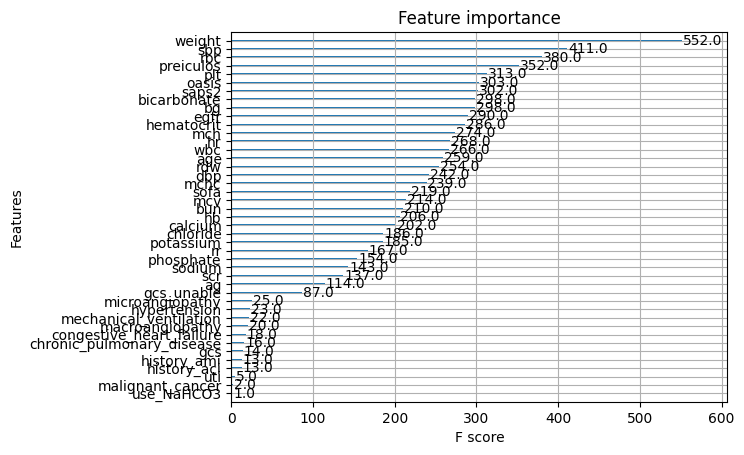

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

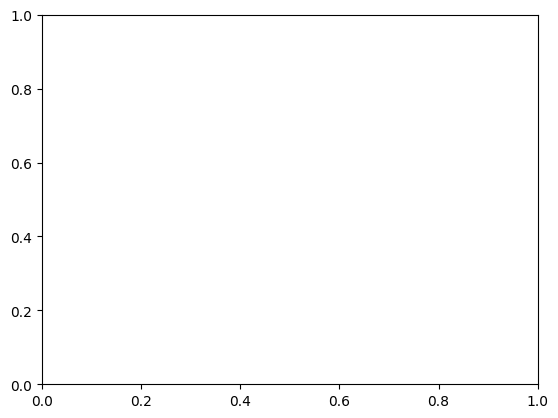

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how, getUntilAkiPositive=True
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))

[0]	validation_0-logloss:0.66633


[1]	validation_0-logloss:0.66314


[2]	validation_0-logloss:0.66161


[3]	validation_0-logloss:0.65948


[4]	validation_0-logloss:0.65744


[5]	validation_0-logloss:0.65558


[6]	validation_0-logloss:0.65413


[7]	validation_0-logloss:0.65150


[8]	validation_0-logloss:0.64904


[9]	validation_0-logloss:0.64681


[10]	validation_0-logloss:0.64439


[11]	validation_0-logloss:0.64276


[12]	validation_0-logloss:0.64181


[13]	validation_0-logloss:0.64034


[14]	validation_0-logloss:0.63894


[15]	validation_0-logloss:0.63679


[16]	validation_0-logloss:0.63470


[17]	validation_0-logloss:0.63290


[18]	validation_0-logloss:0.63167


[19]	validation_0-logloss:0.62993


[20]	validation_0-logloss:0.62834


[21]	validation_0-logloss:0.62647


[22]	validation_0-logloss:0.62445


[23]	validation_0-logloss:0.62302


[24]	validation_0-logloss:0.62249


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:23:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[25]	validation_0-logloss:0.62126


[26]	validation_0-logloss:0.62002


[27]	validation_0-logloss:0.61839


[28]	validation_0-logloss:0.61686


[29]	validation_0-logloss:0.61507


[30]	validation_0-logloss:0.61352


[31]	validation_0-logloss:0.61209


[32]	validation_0-logloss:0.61081


[33]	validation_0-logloss:0.60994


[34]	validation_0-logloss:0.60934


[35]	validation_0-logloss:0.60771


[36]	validation_0-logloss:0.60631


[37]	validation_0-logloss:0.60515


[38]	validation_0-logloss:0.60395


[39]	validation_0-logloss:0.60292


[40]	validation_0-logloss:0.60133


[41]	validation_0-logloss:0.60040


[42]	validation_0-logloss:0.59902


[43]	validation_0-logloss:0.59769


[44]	validation_0-logloss:0.59622


[45]	validation_0-logloss:0.59465


[46]	validation_0-logloss:0.59376


[47]	validation_0-logloss:0.59297


[48]	validation_0-logloss:0.59140


[49]	validation_0-logloss:0.59047


[50]	validation_0-logloss:0.58925


[51]	validation_0-logloss:0.58815


[52]	validation_0-logloss:0.58698


[53]	validation_0-logloss:0.58558


[54]	validation_0-logloss:0.58446


[55]	validation_0-logloss:0.58337


[56]	validation_0-logloss:0.58281


[57]	validation_0-logloss:0.58204


[58]	validation_0-logloss:0.58154


[59]	validation_0-logloss:0.58051


[60]	validation_0-logloss:0.57951


[61]	validation_0-logloss:0.57849


[62]	validation_0-logloss:0.57728


[63]	validation_0-logloss:0.57629


[64]	validation_0-logloss:0.57532


[65]	validation_0-logloss:0.57463


[66]	validation_0-logloss:0.57358


[67]	validation_0-logloss:0.57302


[68]	validation_0-logloss:0.57212


[69]	validation_0-logloss:0.57102


[70]	validation_0-logloss:0.57064


[71]	validation_0-logloss:0.57015


[72]	validation_0-logloss:0.56965


[73]	validation_0-logloss:0.56885


[74]	validation_0-logloss:0.56761


[75]	validation_0-logloss:0.56685


[76]	validation_0-logloss:0.56645


[77]	validation_0-logloss:0.56545


[78]	validation_0-logloss:0.56511


[79]	validation_0-logloss:0.56486


[80]	validation_0-logloss:0.56371


[81]	validation_0-logloss:0.56244


[82]	validation_0-logloss:0.56177


[83]	validation_0-logloss:0.56095


[84]	validation_0-logloss:0.56018


[85]	validation_0-logloss:0.55903


[86]	validation_0-logloss:0.55867


[87]	validation_0-logloss:0.55823


[88]	validation_0-logloss:0.55755


[89]	validation_0-logloss:0.55659

[90]	validation_0-logloss:0.55611


[91]	validation_0-logloss:0.55614


[92]	validation_0-logloss:0.55565


[93]	validation_0-logloss:0.55537


[94]	validation_0-logloss:0.55483


[95]	validation_0-logloss:0.55427


[96]	validation_0-logloss:0.55367


[97]	validation_0-logloss:0.55343


[98]	validation_0-logloss:0.55261


[99]	validation_0-logloss:0.55200


[100]	validation_0-logloss:0.55182


[101]	validation_0-logloss:0.55132


[102]	validation_0-logloss:0.55033


[103]	validation_0-logloss:0.54965


[104]	validation_0-logloss:0.54953


[105]	validation_0-logloss:0.54880


[106]	validation_0-logloss:0.54833


[107]	validation_0-logloss:0.54766


[108]	validation_0-logloss:0.54717

[109]	validation_0-logloss:0.54670


[110]	validation_0-logloss:0.54671


[111]	validation_0-logloss:0.54657


[112]	validation_0-logloss:0.54602


[113]	validation_0-logloss:0.54525


[114]	validation_0-logloss:0.54504


[115]	validation_0-logloss:0.54457


[116]	validation_0-logloss:0.54451


[117]	validation_0-logloss:0.54368

[118]	validation_0-logloss:0.54303


[119]	validation_0-logloss:0.54252


[120]	validation_0-logloss:0.54184

[121]	validation_0-logloss:0.54140


[122]	validation_0-logloss:0.54123


[123]	validation_0-logloss:0.54097


[124]	validation_0-logloss:0.54022


[125]	validation_0-logloss:0.53961


[126]	validation_0-logloss:0.53897


[127]	validation_0-logloss:0.53861


[128]	validation_0-logloss:0.53845


[129]	validation_0-logloss:0.53785


[130]	validation_0-logloss:0.53749


[131]	validation_0-logloss:0.53689


[132]	validation_0-logloss:0.53606


[133]	validation_0-logloss:0.53595


[134]	validation_0-logloss:0.53583


[135]	validation_0-logloss:0.53545


[136]	validation_0-logloss:0.53530


[137]	validation_0-logloss:0.53507


[138]	validation_0-logloss:0.53497


[139]	validation_0-logloss:0.53493


[140]	validation_0-logloss:0.53429


[141]	validation_0-logloss:0.53394


[142]	validation_0-logloss:0.53354


[143]	validation_0-logloss:0.53283


[144]	validation_0-logloss:0.53281


[145]	validation_0-logloss:0.53251


[146]	validation_0-logloss:0.53231


[147]	validation_0-logloss:0.53195

[148]	validation_0-logloss:0.53151


[149]	validation_0-logloss:0.53132


[150]	validation_0-logloss:0.53090


[151]	validation_0-logloss:0.53069


[152]	validation_0-logloss:0.53015


[153]	validation_0-logloss:0.53005


[154]	validation_0-logloss:0.52990


[155]	validation_0-logloss:0.52982


[156]	validation_0-logloss:0.52946


[157]	validation_0-logloss:0.52952


[158]	validation_0-logloss:0.52918


[159]	validation_0-logloss:0.52841


[160]	validation_0-logloss:0.52828


[161]	validation_0-logloss:0.52789


[162]	validation_0-logloss:0.52750


[163]	validation_0-logloss:0.52686


[164]	validation_0-logloss:0.52675


[165]	validation_0-logloss:0.52668

[166]	validation_0-logloss:0.52675


[167]	validation_0-logloss:0.52687


[168]	validation_0-logloss:0.52659


[169]	validation_0-logloss:0.52674


[170]	validation_0-logloss:0.52648


[171]	validation_0-logloss:0.52652


[172]	validation_0-logloss:0.52645


[173]	validation_0-logloss:0.52609


[174]	validation_0-logloss:0.52570


[175]	validation_0-logloss:0.52542


[176]	validation_0-logloss:0.52510

[177]	validation_0-logloss:0.52524


[178]	validation_0-logloss:0.52495


[179]	validation_0-logloss:0.52478


[180]	validation_0-logloss:0.52462


[181]	validation_0-logloss:0.52443


[182]	validation_0-logloss:0.52412


[183]	validation_0-logloss:0.52421


[184]	validation_0-logloss:0.52411


[185]	validation_0-logloss:0.52393


[186]	validation_0-logloss:0.52388


[187]	validation_0-logloss:0.52381


[188]	validation_0-logloss:0.52365


[189]	validation_0-logloss:0.52346


[190]	validation_0-logloss:0.52359


[191]	validation_0-logloss:0.52352


[192]	validation_0-logloss:0.52355


[193]	validation_0-logloss:0.52340


[194]	validation_0-logloss:0.52280


[195]	validation_0-logloss:0.52217


[196]	validation_0-logloss:0.52194


[197]	validation_0-logloss:0.52197

[198]	validation_0-logloss:0.52194


[199]	validation_0-logloss:0.52166


[200]	validation_0-logloss:0.52145

[201]	validation_0-logloss:0.52135


[202]	validation_0-logloss:0.52129


[203]	validation_0-logloss:0.52143


[204]	validation_0-logloss:0.52119


[205]	validation_0-logloss:0.52142


[206]	validation_0-logloss:0.52146


[207]	validation_0-logloss:0.52121


[208]	validation_0-logloss:0.52119


[209]	validation_0-logloss:0.52086


[210]	validation_0-logloss:0.52096


[211]	validation_0-logloss:0.52108


[212]	validation_0-logloss:0.52095


[213]	validation_0-logloss:0.52085


[214]	validation_0-logloss:0.52115


[215]	validation_0-logloss:0.52128


[216]	validation_0-logloss:0.52104


[217]	validation_0-logloss:0.52103


[218]	validation_0-logloss:0.52107


[219]	validation_0-logloss:0.52062


[220]	validation_0-logloss:0.52035


[221]	validation_0-logloss:0.52007


[222]	validation_0-logloss:0.52025


[223]	validation_0-logloss:0.52031


[224]	validation_0-logloss:0.52029


[225]	validation_0-logloss:0.52043


[226]	validation_0-logloss:0.52014


[227]	validation_0-logloss:0.52013


[228]	validation_0-logloss:0.52017


[229]	validation_0-logloss:0.51981


[230]	validation_0-logloss:0.51996


[231]	validation_0-logloss:0.51977


[232]	validation_0-logloss:0.51972


[233]	validation_0-logloss:0.51987


[234]	validation_0-logloss:0.51965


[235]	validation_0-logloss:0.51958


[236]	validation_0-logloss:0.51953


[237]	validation_0-logloss:0.51909


[238]	validation_0-logloss:0.51922


[239]	validation_0-logloss:0.51897


[240]	validation_0-logloss:0.51912

[241]	validation_0-logloss:0.51900


[242]	validation_0-logloss:0.51884


[243]	validation_0-logloss:0.51868


[244]	validation_0-logloss:0.51857


[245]	validation_0-logloss:0.51832


[246]	validation_0-logloss:0.51804

[247]	validation_0-logloss:0.51778


[248]	validation_0-logloss:0.51770


[249]	validation_0-logloss:0.51732


[250]	validation_0-logloss:0.51713


[251]	validation_0-logloss:0.51718


[252]	validation_0-logloss:0.51685


[253]	validation_0-logloss:0.51661


[254]	validation_0-logloss:0.51684

[255]	validation_0-logloss:0.51713


[256]	validation_0-logloss:0.51706


[257]	validation_0-logloss:0.51717


[258]	validation_0-logloss:0.51745


[259]	validation_0-logloss:0.51729


[260]	validation_0-logloss:0.51707


[261]	validation_0-logloss:0.51675


[262]	validation_0-logloss:0.51659


[263]	validation_0-logloss:0.51647


[264]	validation_0-logloss:0.51638


[265]	validation_0-logloss:0.51610


[266]	validation_0-logloss:0.51623


[267]	validation_0-logloss:0.51659


[268]	validation_0-logloss:0.51668

[269]	validation_0-logloss:0.51685


[270]	validation_0-logloss:0.51668


[271]	validation_0-logloss:0.51653


[272]	validation_0-logloss:0.51634


[273]	validation_0-logloss:0.51622


[274]	validation_0-logloss:0.51634


[275]	validation_0-logloss:0.51623


[0]	validation_0-logloss:0.66787


[1]	validation_0-logloss:0.66552


[2]	validation_0-logloss:0.66337


[3]	validation_0-logloss:0.66096


[4]	validation_0-logloss:0.65803


[5]	validation_0-logloss:0.65552


[6]	validation_0-logloss:0.65352


[7]	validation_0-logloss:0.65160


[8]	validation_0-logloss:0.64973


[9]	validation_0-logloss:0.64780


[10]	validation_0-logloss:0.64564


[11]	validation_0-logloss:0.64383


[12]	validation_0-logloss:0.64206


[13]	validation_0-logloss:0.63997


[14]	validation_0-logloss:0.63813


[15]	validation_0-logloss:0.63651


[16]	validation_0-logloss:0.63466


[17]	validation_0-logloss:0.63363


[18]	validation_0-logloss:0.63252


[19]	validation_0-logloss:0.62973


[20]	validation_0-logloss:0.62768


[21]	validation_0-logloss:0.62499


[22]	validation_0-logloss:0.62317


[23]	validation_0-logloss:0.62185


[24]	validation_0-logloss:0.62018


[25]	validation_0-logloss:0.61826


[26]	validation_0-logloss:0.61687


[27]	validation_0-logloss:0.61516


[28]	validation_0-logloss:0.61355


[29]	validation_0-logloss:0.61187


[30]	validation_0-logloss:0.61036


[31]	validation_0-logloss:0.60864


[32]	validation_0-logloss:0.60769


[33]	validation_0-logloss:0.60658


[34]	validation_0-logloss:0.60515


[35]	validation_0-logloss:0.60333


[36]	validation_0-logloss:0.60173


[37]	validation_0-logloss:0.60090


[38]	validation_0-logloss:0.59922


[39]	validation_0-logloss:0.59731


[40]	validation_0-logloss:0.59615


[41]	validation_0-logloss:0.59494


[42]	validation_0-logloss:0.59341


[43]	validation_0-logloss:0.59258


[44]	validation_0-logloss:0.59114


[45]	validation_0-logloss:0.59014


[46]	validation_0-logloss:0.58887


[47]	validation_0-logloss:0.58733


[48]	validation_0-logloss:0.58629


[49]	validation_0-logloss:0.58511


[50]	validation_0-logloss:0.58432


[51]	validation_0-logloss:0.58302


[52]	validation_0-logloss:0.58181


[53]	validation_0-logloss:0.58110


[54]	validation_0-logloss:0.57985


[55]	validation_0-logloss:0.57879


[56]	validation_0-logloss:0.57789


[57]	validation_0-logloss:0.57666


[58]	validation_0-logloss:0.57521


[59]	validation_0-logloss:0.57420


[60]	validation_0-logloss:0.57358


[61]	validation_0-logloss:0.57259


[62]	validation_0-logloss:0.57124


[63]	validation_0-logloss:0.57005


[64]	validation_0-logloss:0.56937


[65]	validation_0-logloss:0.56823


[66]	validation_0-logloss:0.56743


[67]	validation_0-logloss:0.56647


[68]	validation_0-logloss:0.56541


[69]	validation_0-logloss:0.56472


[70]	validation_0-logloss:0.56389


[71]	validation_0-logloss:0.56320


[72]	validation_0-logloss:0.56219


[73]	validation_0-logloss:0.56115


[74]	validation_0-logloss:0.56028


[75]	validation_0-logloss:0.55899


[76]	validation_0-logloss:0.55839


[77]	validation_0-logloss:0.55755


[78]	validation_0-logloss:0.55686


[79]	validation_0-logloss:0.55599


[80]	validation_0-logloss:0.55558


[81]	validation_0-logloss:0.55481


[82]	validation_0-logloss:0.55427


[83]	validation_0-logloss:0.55336


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:23:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[84]	validation_0-logloss:0.55271


[85]	validation_0-logloss:0.55190


[86]	validation_0-logloss:0.55117


[87]	validation_0-logloss:0.55020


[88]	validation_0-logloss:0.54939


[89]	validation_0-logloss:0.54885


[90]	validation_0-logloss:0.54797


[91]	validation_0-logloss:0.54731


[92]	validation_0-logloss:0.54669


[93]	validation_0-logloss:0.54576


[94]	validation_0-logloss:0.54500


[95]	validation_0-logloss:0.54404


[96]	validation_0-logloss:0.54367


[97]	validation_0-logloss:0.54300


[98]	validation_0-logloss:0.54225

[99]	validation_0-logloss:0.54201


[100]	validation_0-logloss:0.54177


[101]	validation_0-logloss:0.54136


[102]	validation_0-logloss:0.54100


[103]	validation_0-logloss:0.54033


[104]	validation_0-logloss:0.54032


[105]	validation_0-logloss:0.53975


[106]	validation_0-logloss:0.53927


[107]	validation_0-logloss:0.53857


[108]	validation_0-logloss:0.53772


[109]	validation_0-logloss:0.53742


[110]	validation_0-logloss:0.53712


[111]	validation_0-logloss:0.53689


[112]	validation_0-logloss:0.53658


[113]	validation_0-logloss:0.53655


[114]	validation_0-logloss:0.53590


[115]	validation_0-logloss:0.53558


[116]	validation_0-logloss:0.53501


[117]	validation_0-logloss:0.53431


[118]	validation_0-logloss:0.53338


[119]	validation_0-logloss:0.53298


[120]	validation_0-logloss:0.53241


[121]	validation_0-logloss:0.53184


[122]	validation_0-logloss:0.53145


[123]	validation_0-logloss:0.53103


[124]	validation_0-logloss:0.53057


[125]	validation_0-logloss:0.52994


[126]	validation_0-logloss:0.52950


[127]	validation_0-logloss:0.52898


[128]	validation_0-logloss:0.52841


[129]	validation_0-logloss:0.52786


[130]	validation_0-logloss:0.52711


[131]	validation_0-logloss:0.52668


[132]	validation_0-logloss:0.52641


[133]	validation_0-logloss:0.52616


[134]	validation_0-logloss:0.52557


[135]	validation_0-logloss:0.52479


[136]	validation_0-logloss:0.52450


[137]	validation_0-logloss:0.52443


[138]	validation_0-logloss:0.52423


[139]	validation_0-logloss:0.52363


[140]	validation_0-logloss:0.52359


[141]	validation_0-logloss:0.52301


[142]	validation_0-logloss:0.52248


[143]	validation_0-logloss:0.52188


[144]	validation_0-logloss:0.52150


[145]	validation_0-logloss:0.52106


[146]	validation_0-logloss:0.52074


[147]	validation_0-logloss:0.52013


[148]	validation_0-logloss:0.51955


[149]	validation_0-logloss:0.51907


[150]	validation_0-logloss:0.51864


[151]	validation_0-logloss:0.51812


[152]	validation_0-logloss:0.51780


[153]	validation_0-logloss:0.51714


[154]	validation_0-logloss:0.51661


[155]	validation_0-logloss:0.51646


[156]	validation_0-logloss:0.51613


[157]	validation_0-logloss:0.51593


[158]	validation_0-logloss:0.51629


[159]	validation_0-logloss:0.51595


[160]	validation_0-logloss:0.51581


[161]	validation_0-logloss:0.51556


[162]	validation_0-logloss:0.51556


[163]	validation_0-logloss:0.51556


[164]	validation_0-logloss:0.51556

[165]	validation_0-logloss:0.51524


[166]	validation_0-logloss:0.51472


[167]	validation_0-logloss:0.51443


[168]	validation_0-logloss:0.51397


[169]	validation_0-logloss:0.51356


[170]	validation_0-logloss:0.51308


[171]	validation_0-logloss:0.51289

[172]	validation_0-logloss:0.51288


[173]	validation_0-logloss:0.51241


[174]	validation_0-logloss:0.51229


[175]	validation_0-logloss:0.51207

[176]	validation_0-logloss:0.51166

[177]	validation_0-logloss:0.51146


[178]	validation_0-logloss:0.51110


[179]	validation_0-logloss:0.51114


[180]	validation_0-logloss:0.51079


[181]	validation_0-logloss:0.51068


[182]	validation_0-logloss:0.51034


[183]	validation_0-logloss:0.51020


[184]	validation_0-logloss:0.50979


[185]	validation_0-logloss:0.50977


[186]	validation_0-logloss:0.50961


[187]	validation_0-logloss:0.50954


[188]	validation_0-logloss:0.50951


[189]	validation_0-logloss:0.50968


[190]	validation_0-logloss:0.50920


[191]	validation_0-logloss:0.50914


[192]	validation_0-logloss:0.50869


[193]	validation_0-logloss:0.50818


[194]	validation_0-logloss:0.50785


[195]	validation_0-logloss:0.50774


[196]	validation_0-logloss:0.50754


[197]	validation_0-logloss:0.50753


[198]	validation_0-logloss:0.50749


[199]	validation_0-logloss:0.50729


[200]	validation_0-logloss:0.50718


[201]	validation_0-logloss:0.50686


[202]	validation_0-logloss:0.50676


[203]	validation_0-logloss:0.50673


[204]	validation_0-logloss:0.50679


[205]	validation_0-logloss:0.50668


[206]	validation_0-logloss:0.50659


[207]	validation_0-logloss:0.50646


[208]	validation_0-logloss:0.50620


[209]	validation_0-logloss:0.50612


[210]	validation_0-logloss:0.50596


[211]	validation_0-logloss:0.50602


[212]	validation_0-logloss:0.50583


[213]	validation_0-logloss:0.50568


[214]	validation_0-logloss:0.50549


[215]	validation_0-logloss:0.50542


[216]	validation_0-logloss:0.50491


[217]	validation_0-logloss:0.50477


[218]	validation_0-logloss:0.50446


[219]	validation_0-logloss:0.50422


[220]	validation_0-logloss:0.50410


[221]	validation_0-logloss:0.50365


[222]	validation_0-logloss:0.50339


[223]	validation_0-logloss:0.50340


[224]	validation_0-logloss:0.50308


[225]	validation_0-logloss:0.50298


[226]	validation_0-logloss:0.50332


[227]	validation_0-logloss:0.50317


[228]	validation_0-logloss:0.50311

[229]	validation_0-logloss:0.50299

[230]	validation_0-logloss:0.50288


[231]	validation_0-logloss:0.50303


[232]	validation_0-logloss:0.50288


[233]	validation_0-logloss:0.50286


[234]	validation_0-logloss:0.50278


[235]	validation_0-logloss:0.50265


[236]	validation_0-logloss:0.50246


[237]	validation_0-logloss:0.50240


[238]	validation_0-logloss:0.50194


[239]	validation_0-logloss:0.50165


[240]	validation_0-logloss:0.50137


[241]	validation_0-logloss:0.50137


[242]	validation_0-logloss:0.50142


[243]	validation_0-logloss:0.50130


[244]	validation_0-logloss:0.50078


[245]	validation_0-logloss:0.50081


[246]	validation_0-logloss:0.50080


[247]	validation_0-logloss:0.50096


[248]	validation_0-logloss:0.50083


[249]	validation_0-logloss:0.50066


[250]	validation_0-logloss:0.50056


[251]	validation_0-logloss:0.50061


[252]	validation_0-logloss:0.50077


[253]	validation_0-logloss:0.50028


[254]	validation_0-logloss:0.50014


[255]	validation_0-logloss:0.50023


[256]	validation_0-logloss:0.49996


[257]	validation_0-logloss:0.50010


[258]	validation_0-logloss:0.50018


[259]	validation_0-logloss:0.50027


[260]	validation_0-logloss:0.50037


[261]	validation_0-logloss:0.50013


[262]	validation_0-logloss:0.49998


[263]	validation_0-logloss:0.49978


[264]	validation_0-logloss:0.49941


[265]	validation_0-logloss:0.49977


[266]	validation_0-logloss:0.49997


[267]	validation_0-logloss:0.49976


[268]	validation_0-logloss:0.49961


[269]	validation_0-logloss:0.49986


[270]	validation_0-logloss:0.49975


[271]	validation_0-logloss:0.49974


[272]	validation_0-logloss:0.49984


[273]	validation_0-logloss:0.49976


[274]	validation_0-logloss:0.49962


[0]	validation_0-logloss:0.66817


[1]	validation_0-logloss:0.66625


[2]	validation_0-logloss:0.66464


[3]	validation_0-logloss:0.66277


[4]	validation_0-logloss:0.66065


[5]	validation_0-logloss:0.65870


[6]	validation_0-logloss:0.65700


[7]	validation_0-logloss:0.65492


[8]	validation_0-logloss:0.65273


[9]	validation_0-logloss:0.65082


[10]	validation_0-logloss:0.64877


[11]	validation_0-logloss:0.64705


[12]	validation_0-logloss:0.64541


[13]	validation_0-logloss:0.64402


[14]	validation_0-logloss:0.64217


[15]	validation_0-logloss:0.64070


[16]	validation_0-logloss:0.63913


[17]	validation_0-logloss:0.63743


[18]	validation_0-logloss:0.63624


[19]	validation_0-logloss:0.63486


[20]	validation_0-logloss:0.63355


[21]	validation_0-logloss:0.63173


[22]	validation_0-logloss:0.63073


[23]	validation_0-logloss:0.62884


[24]	validation_0-logloss:0.62840


[25]	validation_0-logloss:0.62747


[26]	validation_0-logloss:0.62611


[27]	validation_0-logloss:0.62472


[28]	validation_0-logloss:0.62325


[29]	validation_0-logloss:0.62226


[30]	validation_0-logloss:0.62123


[31]	validation_0-logloss:0.62011


[32]	validation_0-logloss:0.61953


[33]	validation_0-logloss:0.61833


[34]	validation_0-logloss:0.61762


[35]	validation_0-logloss:0.61620


[36]	validation_0-logloss:0.61514


[37]	validation_0-logloss:0.61445


[38]	validation_0-logloss:0.61376


[39]	validation_0-logloss:0.61322


[40]	validation_0-logloss:0.61219


[41]	validation_0-logloss:0.61097


[42]	validation_0-logloss:0.61006


[43]	validation_0-logloss:0.60856


[44]	validation_0-logloss:0.60728


[45]	validation_0-logloss:0.60663


[46]	validation_0-logloss:0.60611


[47]	validation_0-logloss:0.60522


[48]	validation_0-logloss:0.60433


[49]	validation_0-logloss:0.60319


[50]	validation_0-logloss:0.60221


[51]	validation_0-logloss:0.60150


[52]	validation_0-logloss:0.60104


[53]	validation_0-logloss:0.60047


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:24:03] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[54]	validation_0-logloss:0.59984


[55]	validation_0-logloss:0.59922


[56]	validation_0-logloss:0.59855


[57]	validation_0-logloss:0.59775


[58]	validation_0-logloss:0.59696

[59]	validation_0-logloss:0.59643


[60]	validation_0-logloss:0.59574


[61]	validation_0-logloss:0.59481


[62]	validation_0-logloss:0.59451


[63]	validation_0-logloss:0.59385


[64]	validation_0-logloss:0.59336


[65]	validation_0-logloss:0.59296


[66]	validation_0-logloss:0.59216


[67]	validation_0-logloss:0.59139


[68]	validation_0-logloss:0.59059


[69]	validation_0-logloss:0.58968


[70]	validation_0-logloss:0.58891


[71]	validation_0-logloss:0.58834


[72]	validation_0-logloss:0.58755


[73]	validation_0-logloss:0.58696


[74]	validation_0-logloss:0.58602


[75]	validation_0-logloss:0.58497


[76]	validation_0-logloss:0.58475


[77]	validation_0-logloss:0.58428


[78]	validation_0-logloss:0.58346


[79]	validation_0-logloss:0.58278


[80]	validation_0-logloss:0.58273


[81]	validation_0-logloss:0.58207


[82]	validation_0-logloss:0.58155


[83]	validation_0-logloss:0.58116


[84]	validation_0-logloss:0.58035


[85]	validation_0-logloss:0.58006


[86]	validation_0-logloss:0.57889


[87]	validation_0-logloss:0.57859


[88]	validation_0-logloss:0.57789


[89]	validation_0-logloss:0.57762


[90]	validation_0-logloss:0.57711


[91]	validation_0-logloss:0.57678


[92]	validation_0-logloss:0.57628


[93]	validation_0-logloss:0.57577


[94]	validation_0-logloss:0.57530


[95]	validation_0-logloss:0.57539


[96]	validation_0-logloss:0.57520


[97]	validation_0-logloss:0.57484


[98]	validation_0-logloss:0.57458


[99]	validation_0-logloss:0.57447


[100]	validation_0-logloss:0.57458


[101]	validation_0-logloss:0.57417

[102]	validation_0-logloss:0.57384


[103]	validation_0-logloss:0.57318


[104]	validation_0-logloss:0.57235


[105]	validation_0-logloss:0.57192

[106]	validation_0-logloss:0.57166


[107]	validation_0-logloss:0.57137


[108]	validation_0-logloss:0.57072


[109]	validation_0-logloss:0.57036


[110]	validation_0-logloss:0.57016


[111]	validation_0-logloss:0.56970


[112]	validation_0-logloss:0.56910


[113]	validation_0-logloss:0.56889


[114]	validation_0-logloss:0.56851


[115]	validation_0-logloss:0.56839


[116]	validation_0-logloss:0.56808


[117]	validation_0-logloss:0.56755


[118]	validation_0-logloss:0.56743


[119]	validation_0-logloss:0.56699


[120]	validation_0-logloss:0.56677


[121]	validation_0-logloss:0.56668


[122]	validation_0-logloss:0.56622


[123]	validation_0-logloss:0.56577


[124]	validation_0-logloss:0.56562


[125]	validation_0-logloss:0.56534


[126]	validation_0-logloss:0.56563


[127]	validation_0-logloss:0.56485


[128]	validation_0-logloss:0.56452

[129]	validation_0-logloss:0.56414


[130]	validation_0-logloss:0.56415


[131]	validation_0-logloss:0.56406


[132]	validation_0-logloss:0.56399


[133]	validation_0-logloss:0.56360

[134]	validation_0-logloss:0.56360


[135]	validation_0-logloss:0.56323

[136]	validation_0-logloss:0.56294

[137]	validation_0-logloss:0.56277


[138]	validation_0-logloss:0.56268


[139]	validation_0-logloss:0.56228


[140]	validation_0-logloss:0.56207


[141]	validation_0-logloss:0.56162


[142]	validation_0-logloss:0.56126


[143]	validation_0-logloss:0.56114


[144]	validation_0-logloss:0.56101


[145]	validation_0-logloss:0.56112


[146]	validation_0-logloss:0.56049


[147]	validation_0-logloss:0.56024


[148]	validation_0-logloss:0.55978


[149]	validation_0-logloss:0.55938

[150]	validation_0-logloss:0.55931


[151]	validation_0-logloss:0.55879


[152]	validation_0-logloss:0.55857


[153]	validation_0-logloss:0.55848

[154]	validation_0-logloss:0.55792


[155]	validation_0-logloss:0.55795


[156]	validation_0-logloss:0.55773


[157]	validation_0-logloss:0.55729


[158]	validation_0-logloss:0.55715


[159]	validation_0-logloss:0.55658


[160]	validation_0-logloss:0.55664


[161]	validation_0-logloss:0.55661


[162]	validation_0-logloss:0.55654

[163]	validation_0-logloss:0.55658


[164]	validation_0-logloss:0.55632


[165]	validation_0-logloss:0.55633


[166]	validation_0-logloss:0.55632


[167]	validation_0-logloss:0.55570


[168]	validation_0-logloss:0.55563


[169]	validation_0-logloss:0.55546


[170]	validation_0-logloss:0.55551


[171]	validation_0-logloss:0.55569


[172]	validation_0-logloss:0.55567


[173]	validation_0-logloss:0.55602

[174]	validation_0-logloss:0.55588


[175]	validation_0-logloss:0.55529


[176]	validation_0-logloss:0.55485


[177]	validation_0-logloss:0.55455


[178]	validation_0-logloss:0.55413


[179]	validation_0-logloss:0.55400


[180]	validation_0-logloss:0.55415


[181]	validation_0-logloss:0.55395


[182]	validation_0-logloss:0.55394


[183]	validation_0-logloss:0.55388


[184]	validation_0-logloss:0.55361


[185]	validation_0-logloss:0.55330


[186]	validation_0-logloss:0.55296


[187]	validation_0-logloss:0.55279

[188]	validation_0-logloss:0.55280


[189]	validation_0-logloss:0.55239


[190]	validation_0-logloss:0.55212


[191]	validation_0-logloss:0.55179


[192]	validation_0-logloss:0.55160


[193]	validation_0-logloss:0.55139


[194]	validation_0-logloss:0.55116


[195]	validation_0-logloss:0.55147


[196]	validation_0-logloss:0.55148


[197]	validation_0-logloss:0.55173


[198]	validation_0-logloss:0.55178


[199]	validation_0-logloss:0.55166


[200]	validation_0-logloss:0.55153


[201]	validation_0-logloss:0.55162

[202]	validation_0-logloss:0.55133


[203]	validation_0-logloss:0.55094


[204]	validation_0-logloss:0.55080


[205]	validation_0-logloss:0.55073


[206]	validation_0-logloss:0.55089


[207]	validation_0-logloss:0.55071


[208]	validation_0-logloss:0.55068


[209]	validation_0-logloss:0.55012


[210]	validation_0-logloss:0.54999


[211]	validation_0-logloss:0.54985


[212]	validation_0-logloss:0.54991


[213]	validation_0-logloss:0.55004


[214]	validation_0-logloss:0.54974

[215]	validation_0-logloss:0.54976


[216]	validation_0-logloss:0.55000


[217]	validation_0-logloss:0.54981


[218]	validation_0-logloss:0.54949


[219]	validation_0-logloss:0.54932


[220]	validation_0-logloss:0.54912


[221]	validation_0-logloss:0.54917


[222]	validation_0-logloss:0.54922


[223]	validation_0-logloss:0.54932


[224]	validation_0-logloss:0.54900


[225]	validation_0-logloss:0.54914


[226]	validation_0-logloss:0.54923


[227]	validation_0-logloss:0.54939


[228]	validation_0-logloss:0.54939


[229]	validation_0-logloss:0.54915


[230]	validation_0-logloss:0.54916


[231]	validation_0-logloss:0.54867


[232]	validation_0-logloss:0.54877


[233]	validation_0-logloss:0.54858


[234]	validation_0-logloss:0.54857


[235]	validation_0-logloss:0.54897


[236]	validation_0-logloss:0.54890


[237]	validation_0-logloss:0.54876


[238]	validation_0-logloss:0.54873


[239]	validation_0-logloss:0.54885


[240]	validation_0-logloss:0.54888


[241]	validation_0-logloss:0.54909


[242]	validation_0-logloss:0.54890


[243]	validation_0-logloss:0.54896

[0]	validation_0-logloss:0.66849


[1]	validation_0-logloss:0.66611


[2]	validation_0-logloss:0.66340


[3]	validation_0-logloss:0.66136


[4]	validation_0-logloss:0.65939


[5]	validation_0-logloss:0.65690


[6]	validation_0-logloss:0.65503


[7]	validation_0-logloss:0.65238


[8]	validation_0-logloss:0.65110


[9]	validation_0-logloss:0.64988


[10]	validation_0-logloss:0.64834


[11]	validation_0-logloss:0.64649


[12]	validation_0-logloss:0.64469


[13]	validation_0-logloss:0.64315


[14]	validation_0-logloss:0.64102


[15]	validation_0-logloss:0.63967


[16]	validation_0-logloss:0.63736


[17]	validation_0-logloss:0.63585


[18]	validation_0-logloss:0.63443


[19]	validation_0-logloss:0.63363


[20]	validation_0-logloss:0.63161


[21]	validation_0-logloss:0.63003


[22]	validation_0-logloss:0.62816


[23]	validation_0-logloss:0.62698


[24]	validation_0-logloss:0.62553


[25]	validation_0-logloss:0.62336


[26]	validation_0-logloss:0.62190


[27]	validation_0-logloss:0.61999


[28]	validation_0-logloss:0.61853


[29]	validation_0-logloss:0.61741


[30]	validation_0-logloss:0.61585


[31]	validation_0-logloss:0.61469


[32]	validation_0-logloss:0.61382


[33]	validation_0-logloss:0.61250


[34]	validation_0-logloss:0.61112


[35]	validation_0-logloss:0.61032


[36]	validation_0-logloss:0.60866


[37]	validation_0-logloss:0.60710


[38]	validation_0-logloss:0.60602


[39]	validation_0-logloss:0.60497


[40]	validation_0-logloss:0.60389


[41]	validation_0-logloss:0.60282


[42]	validation_0-logloss:0.60219


[43]	validation_0-logloss:0.60128


[44]	validation_0-logloss:0.59999


[45]	validation_0-logloss:0.59926


[46]	validation_0-logloss:0.59779


[47]	validation_0-logloss:0.59641


[48]	validation_0-logloss:0.59525


[49]	validation_0-logloss:0.59394


[50]	validation_0-logloss:0.59293


[51]	validation_0-logloss:0.59174


[52]	validation_0-logloss:0.59076


[53]	validation_0-logloss:0.58960


[54]	validation_0-logloss:0.58882


[55]	validation_0-logloss:0.58793


[56]	validation_0-logloss:0.58716


[57]	validation_0-logloss:0.58594


[58]	validation_0-logloss:0.58480


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:24:22] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[59]	validation_0-logloss:0.58426


[60]	validation_0-logloss:0.58335


[61]	validation_0-logloss:0.58227


[62]	validation_0-logloss:0.58104


[63]	validation_0-logloss:0.58063


[64]	validation_0-logloss:0.58011


[65]	validation_0-logloss:0.57909


[66]	validation_0-logloss:0.57863


[67]	validation_0-logloss:0.57737


[68]	validation_0-logloss:0.57641


[69]	validation_0-logloss:0.57595


[70]	validation_0-logloss:0.57518

[71]	validation_0-logloss:0.57509

[72]	validation_0-logloss:0.57427

[73]	validation_0-logloss:0.57324


[74]	validation_0-logloss:0.57223

[75]	validation_0-logloss:0.57199

[76]	validation_0-logloss:0.57118


[77]	validation_0-logloss:0.57065


[78]	validation_0-logloss:0.56932


[79]	validation_0-logloss:0.56864


[80]	validation_0-logloss:0.56732


[81]	validation_0-logloss:0.56639


[82]	validation_0-logloss:0.56570


[83]	validation_0-logloss:0.56483


[84]	validation_0-logloss:0.56388


[85]	validation_0-logloss:0.56285


[86]	validation_0-logloss:0.56228


[87]	validation_0-logloss:0.56134


[88]	validation_0-logloss:0.56048


[89]	validation_0-logloss:0.55964


[90]	validation_0-logloss:0.55909


[91]	validation_0-logloss:0.55867


[92]	validation_0-logloss:0.55844


[93]	validation_0-logloss:0.55770


[94]	validation_0-logloss:0.55687


[95]	validation_0-logloss:0.55634


[96]	validation_0-logloss:0.55575


[97]	validation_0-logloss:0.55544


[98]	validation_0-logloss:0.55504


[99]	validation_0-logloss:0.55452


[100]	validation_0-logloss:0.55439


[101]	validation_0-logloss:0.55395


[102]	validation_0-logloss:0.55303


[103]	validation_0-logloss:0.55249


[104]	validation_0-logloss:0.55199


[105]	validation_0-logloss:0.55151


[106]	validation_0-logloss:0.55107


[107]	validation_0-logloss:0.55036


[108]	validation_0-logloss:0.54991


[109]	validation_0-logloss:0.54968


[110]	validation_0-logloss:0.54935


[111]	validation_0-logloss:0.54911


[112]	validation_0-logloss:0.54857


[113]	validation_0-logloss:0.54830


[114]	validation_0-logloss:0.54809


[115]	validation_0-logloss:0.54776


[116]	validation_0-logloss:0.54692


[117]	validation_0-logloss:0.54695


[118]	validation_0-logloss:0.54663


[119]	validation_0-logloss:0.54620


[120]	validation_0-logloss:0.54581


[121]	validation_0-logloss:0.54566


[122]	validation_0-logloss:0.54544


[123]	validation_0-logloss:0.54478


[124]	validation_0-logloss:0.54449


[125]	validation_0-logloss:0.54407


[126]	validation_0-logloss:0.54390


[127]	validation_0-logloss:0.54361


[128]	validation_0-logloss:0.54348


[129]	validation_0-logloss:0.54299


[130]	validation_0-logloss:0.54255


[131]	validation_0-logloss:0.54213


[132]	validation_0-logloss:0.54185


[133]	validation_0-logloss:0.54149

[134]	validation_0-logloss:0.54115

[135]	validation_0-logloss:0.54093

[136]	validation_0-logloss:0.54088

[137]	validation_0-logloss:0.54088


[138]	validation_0-logloss:0.54062

[139]	validation_0-logloss:0.54040

[140]	validation_0-logloss:0.53974

[141]	validation_0-logloss:0.53920


[142]	validation_0-logloss:0.53862


[143]	validation_0-logloss:0.53829


[144]	validation_0-logloss:0.53785


[145]	validation_0-logloss:0.53737


[146]	validation_0-logloss:0.53719


[147]	validation_0-logloss:0.53716


[148]	validation_0-logloss:0.53660


[149]	validation_0-logloss:0.53636


[150]	validation_0-logloss:0.53611


[151]	validation_0-logloss:0.53580


[152]	validation_0-logloss:0.53540


[153]	validation_0-logloss:0.53507


[154]	validation_0-logloss:0.53451


[155]	validation_0-logloss:0.53428


[156]	validation_0-logloss:0.53388


[157]	validation_0-logloss:0.53372


[158]	validation_0-logloss:0.53349


[159]	validation_0-logloss:0.53310


[160]	validation_0-logloss:0.53261


[161]	validation_0-logloss:0.53218


[162]	validation_0-logloss:0.53183


[163]	validation_0-logloss:0.53131


[164]	validation_0-logloss:0.53134


[165]	validation_0-logloss:0.53115


[166]	validation_0-logloss:0.53050


[167]	validation_0-logloss:0.53013


[168]	validation_0-logloss:0.53005


[169]	validation_0-logloss:0.52985


[170]	validation_0-logloss:0.52970


[171]	validation_0-logloss:0.52912


[172]	validation_0-logloss:0.52877


[173]	validation_0-logloss:0.52853


[174]	validation_0-logloss:0.52819


[175]	validation_0-logloss:0.52812


[176]	validation_0-logloss:0.52759


[177]	validation_0-logloss:0.52703


[178]	validation_0-logloss:0.52674


[179]	validation_0-logloss:0.52665


[180]	validation_0-logloss:0.52604


[181]	validation_0-logloss:0.52605


[182]	validation_0-logloss:0.52591


[183]	validation_0-logloss:0.52560

[184]	validation_0-logloss:0.52552


[185]	validation_0-logloss:0.52525

[186]	validation_0-logloss:0.52538


[187]	validation_0-logloss:0.52519


[188]	validation_0-logloss:0.52499


[189]	validation_0-logloss:0.52481


[190]	validation_0-logloss:0.52469


[191]	validation_0-logloss:0.52445


[192]	validation_0-logloss:0.52437


[193]	validation_0-logloss:0.52414

[194]	validation_0-logloss:0.52414


[195]	validation_0-logloss:0.52395


[196]	validation_0-logloss:0.52413


[197]	validation_0-logloss:0.52371

[198]	validation_0-logloss:0.52337

[199]	validation_0-logloss:0.52327


[200]	validation_0-logloss:0.52321


[201]	validation_0-logloss:0.52317


[202]	validation_0-logloss:0.52312


[203]	validation_0-logloss:0.52307


[204]	validation_0-logloss:0.52319


[205]	validation_0-logloss:0.52334


[206]	validation_0-logloss:0.52328


[207]	validation_0-logloss:0.52343


[208]	validation_0-logloss:0.52320


[209]	validation_0-logloss:0.52333


[210]	validation_0-logloss:0.52299


[211]	validation_0-logloss:0.52307


[212]	validation_0-logloss:0.52288


[213]	validation_0-logloss:0.52316


[214]	validation_0-logloss:0.52323


[215]	validation_0-logloss:0.52307

[216]	validation_0-logloss:0.52295


[217]	validation_0-logloss:0.52332


[218]	validation_0-logloss:0.52306


[219]	validation_0-logloss:0.52288


[220]	validation_0-logloss:0.52302


[221]	validation_0-logloss:0.52273


[222]	validation_0-logloss:0.52302


[223]	validation_0-logloss:0.52311


[224]	validation_0-logloss:0.52322


[225]	validation_0-logloss:0.52312


[226]	validation_0-logloss:0.52331


[227]	validation_0-logloss:0.52320


[228]	validation_0-logloss:0.52309


[229]	validation_0-logloss:0.52299


[230]	validation_0-logloss:0.52306


[0]	validation_0-logloss:0.66798


[1]	validation_0-logloss:0.66572


[2]	validation_0-logloss:0.66308


[3]	validation_0-logloss:0.66099


[4]	validation_0-logloss:0.65884


[5]	validation_0-logloss:0.65654


[6]	validation_0-logloss:0.65462


[7]	validation_0-logloss:0.65284


[8]	validation_0-logloss:0.65071


[9]	validation_0-logloss:0.64905


[10]	validation_0-logloss:0.64705


[11]	validation_0-logloss:0.64555


[12]	validation_0-logloss:0.64361


[13]	validation_0-logloss:0.64185


[14]	validation_0-logloss:0.63964


[15]	validation_0-logloss:0.63840


[16]	validation_0-logloss:0.63623


[17]	validation_0-logloss:0.63419


[18]	validation_0-logloss:0.63243


[19]	validation_0-logloss:0.63110


[20]	validation_0-logloss:0.62965


[21]	validation_0-logloss:0.62837


[22]	validation_0-logloss:0.62660


[23]	validation_0-logloss:0.62525


[24]	validation_0-logloss:0.62426


[25]	validation_0-logloss:0.62282


[26]	validation_0-logloss:0.62147


[27]	validation_0-logloss:0.62022


[28]	validation_0-logloss:0.61869


[29]	validation_0-logloss:0.61754


[30]	validation_0-logloss:0.61627


[31]	validation_0-logloss:0.61480


[32]	validation_0-logloss:0.61331


[33]	validation_0-logloss:0.61163


[34]	validation_0-logloss:0.61013


[35]	validation_0-logloss:0.60924


[36]	validation_0-logloss:0.60829


[37]	validation_0-logloss:0.60704


[38]	validation_0-logloss:0.60636


[39]	validation_0-logloss:0.60528


[40]	validation_0-logloss:0.60409


[41]	validation_0-logloss:0.60348


[42]	validation_0-logloss:0.60203


[43]	validation_0-logloss:0.60113


[44]	validation_0-logloss:0.60050


[45]	validation_0-logloss:0.59942


[46]	validation_0-logloss:0.59820


[47]	validation_0-logloss:0.59699


[48]	validation_0-logloss:0.59618


[49]	validation_0-logloss:0.59510


[50]	validation_0-logloss:0.59427


[51]	validation_0-logloss:0.59318


[52]	validation_0-logloss:0.59234


[53]	validation_0-logloss:0.59120


[54]	validation_0-logloss:0.59045


[55]	validation_0-logloss:0.58955


[56]	validation_0-logloss:0.58884


[57]	validation_0-logloss:0.58799


[58]	validation_0-logloss:0.58731


[59]	validation_0-logloss:0.58636


[60]	validation_0-logloss:0.58564


[61]	validation_0-logloss:0.58453


[62]	validation_0-logloss:0.58347


[63]	validation_0-logloss:0.58266


[64]	validation_0-logloss:0.58179


[65]	validation_0-logloss:0.58112


[66]	validation_0-logloss:0.58035


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [16:24:38] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[67]	validation_0-logloss:0.57977


[68]	validation_0-logloss:0.57914


[69]	validation_0-logloss:0.57819


[70]	validation_0-logloss:0.57758


[71]	validation_0-logloss:0.57711


[72]	validation_0-logloss:0.57641


[73]	validation_0-logloss:0.57556


[74]	validation_0-logloss:0.57475


[75]	validation_0-logloss:0.57436


[76]	validation_0-logloss:0.57382


[77]	validation_0-logloss:0.57304


[78]	validation_0-logloss:0.57237


[79]	validation_0-logloss:0.57204


[80]	validation_0-logloss:0.57158


[81]	validation_0-logloss:0.57107


[82]	validation_0-logloss:0.57076


[83]	validation_0-logloss:0.57051


[84]	validation_0-logloss:0.56981


[85]	validation_0-logloss:0.56915


[86]	validation_0-logloss:0.56851


[87]	validation_0-logloss:0.56791


[88]	validation_0-logloss:0.56727


[89]	validation_0-logloss:0.56658


[90]	validation_0-logloss:0.56593


[91]	validation_0-logloss:0.56558


[92]	validation_0-logloss:0.56529


[93]	validation_0-logloss:0.56539


[94]	validation_0-logloss:0.56550


[95]	validation_0-logloss:0.56489


[96]	validation_0-logloss:0.56466


[97]	validation_0-logloss:0.56376


[98]	validation_0-logloss:0.56321


[99]	validation_0-logloss:0.56253


[100]	validation_0-logloss:0.56182


[101]	validation_0-logloss:0.56156


[102]	validation_0-logloss:0.56131


[103]	validation_0-logloss:0.56066


[104]	validation_0-logloss:0.56034


[105]	validation_0-logloss:0.55971


[106]	validation_0-logloss:0.55934


[107]	validation_0-logloss:0.55924


[108]	validation_0-logloss:0.55872


[109]	validation_0-logloss:0.55826


[110]	validation_0-logloss:0.55820


[111]	validation_0-logloss:0.55797


[112]	validation_0-logloss:0.55719


[113]	validation_0-logloss:0.55664


[114]	validation_0-logloss:0.55625


[115]	validation_0-logloss:0.55612


[116]	validation_0-logloss:0.55617


[117]	validation_0-logloss:0.55598

[118]	validation_0-logloss:0.55571


[119]	validation_0-logloss:0.55544


[120]	validation_0-logloss:0.55507


[121]	validation_0-logloss:0.55488


[122]	validation_0-logloss:0.55459


[123]	validation_0-logloss:0.55350


[124]	validation_0-logloss:0.55295


[125]	validation_0-logloss:0.55252


[126]	validation_0-logloss:0.55224


[127]	validation_0-logloss:0.55200


[128]	validation_0-logloss:0.55167


[129]	validation_0-logloss:0.55175


[130]	validation_0-logloss:0.55153


[131]	validation_0-logloss:0.55139


[132]	validation_0-logloss:0.55118


[133]	validation_0-logloss:0.55072


[134]	validation_0-logloss:0.55016


[135]	validation_0-logloss:0.54979


[136]	validation_0-logloss:0.54926


[137]	validation_0-logloss:0.54913


[138]	validation_0-logloss:0.54884


[139]	validation_0-logloss:0.54857


[140]	validation_0-logloss:0.54846


[141]	validation_0-logloss:0.54843


[142]	validation_0-logloss:0.54847


[143]	validation_0-logloss:0.54847


[144]	validation_0-logloss:0.54826


[145]	validation_0-logloss:0.54809


[146]	validation_0-logloss:0.54724


[147]	validation_0-logloss:0.54736


[148]	validation_0-logloss:0.54720


[149]	validation_0-logloss:0.54668


[150]	validation_0-logloss:0.54664


[151]	validation_0-logloss:0.54636


[152]	validation_0-logloss:0.54594


[153]	validation_0-logloss:0.54594


[154]	validation_0-logloss:0.54576


[155]	validation_0-logloss:0.54534


[156]	validation_0-logloss:0.54487


[157]	validation_0-logloss:0.54482


[158]	validation_0-logloss:0.54443


[159]	validation_0-logloss:0.54433


[160]	validation_0-logloss:0.54436


[161]	validation_0-logloss:0.54422


[162]	validation_0-logloss:0.54355


[163]	validation_0-logloss:0.54333


[164]	validation_0-logloss:0.54318


[165]	validation_0-logloss:0.54306


[166]	validation_0-logloss:0.54243


[167]	validation_0-logloss:0.54234

[168]	validation_0-logloss:0.54214


[169]	validation_0-logloss:0.54219


[170]	validation_0-logloss:0.54200


[171]	validation_0-logloss:0.54179


[172]	validation_0-logloss:0.54177


[173]	validation_0-logloss:0.54142


[174]	validation_0-logloss:0.54137


[175]	validation_0-logloss:0.54114


[176]	validation_0-logloss:0.54127


[177]	validation_0-logloss:0.54114


[178]	validation_0-logloss:0.54095


[179]	validation_0-logloss:0.54102


[180]	validation_0-logloss:0.54064


[181]	validation_0-logloss:0.54087


[182]	validation_0-logloss:0.54052


[183]	validation_0-logloss:0.54022


[184]	validation_0-logloss:0.53983


[185]	validation_0-logloss:0.53976


[186]	validation_0-logloss:0.53922


[187]	validation_0-logloss:0.53915


[188]	validation_0-logloss:0.53920


[189]	validation_0-logloss:0.53902


[190]	validation_0-logloss:0.53838


[191]	validation_0-logloss:0.53832


[192]	validation_0-logloss:0.53820


[193]	validation_0-logloss:0.53828


[194]	validation_0-logloss:0.53781


[195]	validation_0-logloss:0.53766


[196]	validation_0-logloss:0.53755


[197]	validation_0-logloss:0.53731


[198]	validation_0-logloss:0.53747

[199]	validation_0-logloss:0.53740


[200]	validation_0-logloss:0.53701


[201]	validation_0-logloss:0.53730


[202]	validation_0-logloss:0.53744


[203]	validation_0-logloss:0.53737


[204]	validation_0-logloss:0.53777


[205]	validation_0-logloss:0.53780


[206]	validation_0-logloss:0.53784


[207]	validation_0-logloss:0.53744


[208]	validation_0-logloss:0.53742


[209]	validation_0-logloss:0.53730


[210]	validation_0-logloss:0.53744


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7992641907888346
Average Accuracy: 0.7462672747848154
Average Precision: 0.7101083708019617
Average Recall: 0.6013661814109743
